# Lillymol Retrosynthetic Analysis Algorithm

V.F. Scalfani and A.M. Fernandez, University of Alabama Libraries

Fall 2024

## Anticipated Length of Workshop

~ 1 hour

## Important Notes

This notebook is part of the Retrosynthesis Workshop materials, which aim to introduce computational cheminformatics techniques for retrosynthesis prediction. Please note the following:

1. **Educational Purpose**: The tutorials are designed for educational purposes to help you understand cheminformatics strategies for predicting synthetic routes. They are not intended to provide practical laboratory guidance.

2. **Practical Limitations**: The methods demonstrated here are template-based and pattern-driven, meaning they rely on predefined reaction templates and do not fully capture real-world chemistry complexities. It is important to note that computational models can produce inaccurate or incomplete predictions due to simplifications and assumptions within the algorithms, as well as limitations in their training data. Any application of the predicted reactions would require signficant additional research, including a thorough review of the relevant literature, synthesis planning, and safety assessments. In addition, see the articles referenced throughout the Retrosynthesis Workshop notebooks to learn more about specific model limitations.

3. **Intellectual Property**: The retrosynthetic prediction techniques in the tutorials use publicly available reaction data (and/or computer models derived from this data) from U.S. patents for training purposes. Synthetic pathways suggested by these models could potentially be protected by intellectual property laws.

For further details, please refer to the [README](https://github.com/ualibweb/retrosynthesis/blob/main/README.md).


## What is the purpose of this workshop?

The purpose of this workshop is to introduce the open-source LillyMol cheminformatics software and, specifically, its retrosynthesis implementation (https://github.com/EliLillyCo/LillyMol). This technique is deterministic and the key workflow pieces like standardization, signature calculations, and application of retrosynthesis to a target can all be implemented with the LillyMol provided command line programs. The version of LillyMol we will use (v6_cmake) is only distributed as C++ source code, so we will also discuss how to compile and use the software.

## Brief Description of Method

Reaction "signatures" (changing atoms in a reaction core) are extracted from a dataset of standardized and reversed reactions. The specificty of signature can be selected via a radius parameter, where a radius of, for example 2, would include the changing atoms and all atoms within 2 bonds of atoms in the core. The reaction signatures are a unique SMILES like format and can then be used to group reactions with the same signature (i.e., a reaction cluster). A representative reversed reaction is selected for each signature meeting a threshold (e.g., at least 10 occurences) and used as a reaction template. Templates are then used in the retrosynthetic algorithm to construct the signature for a substructure query on the target product [1]. 

Key terminology to keep in mind throughout this notebook:

- "fragments" for reactants and products
- "signatures" describe the reaction cores. This is a unique SMILES like format
- "reaction clusters" are grouped classes of signatures
- "reverse reaction template" a selected representative reaction for a particular signature

## References

[1] Watson, I. A.; Wang, J.; Nicolaou, C. A. A Retrosynthetic Analysis Algorithm Implementation. J Cheminform 2019, 11 (1), 1. https://doi.org/10.1186/s13321-018-0323-6.

[2] https://github.com/EliLillyCo/LillyMol

[3] Nicolaou, C. A.; Watson, I. A.; LeMasters, M.; Masquelin, T.; Wang, J. Context Aware Data-Driven Retrosynthetic Analysis. J. Chem. Inf. Model. 2020, 60 (6), 2728–2738. https://doi.org/10.1021/acs.jcim.9b01141.

[4] Schneider, N.; Stiefl, N.; Landrum, G. A. What’s What: The (Nearly) Definitive Guide to Reaction Role Assignment. J. Chem. Inf. Model. 2016, 56 (12), 2336–2346. https://doi.org/10.1021/acs.jcim.6b00564.

## Reuse Notes

Some of the code in this notebook was adapated from the supporting information rtsa_train.py file in Watson, I. A.; Wang, J.; Nicolaou, C. A. A Retrosynthetic Analysis Algorithm Implementation. J Cheminform 2019, 11 (1), 1. https://doi.org/10.1186/s13321-018-0323-6. It is licensed under the open source Apache License 2.0 and, therefore, this notebook maintains the Apache License 2.0. A copy of the license can be found in this repository, named Lillymol_related_LICENSE


We tried to follow the overall workflow presented in the manuscript within our code for the retrosynthesis prediction parts. If you find mistakes/bugs, please let us know. Also note that we are using LillyMol version 6, which may differ from the version used in the article. In addition, we use a much smaller dataset for the training step.

```
########################################################################
# Copyright 2018 Eli Lilly and Company 
# 
# 
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License. 
# You may obtain a copy of the License at  
# 
#     http://www.apache.org/licenses/LICENSE-2.0  
# 
# Unless required by applicable law or agreed to in writing, software 
# distributed under the License is distributed on an "AS IS" BASIS, 
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. 
# See the License for the specific language governing permissions and 
# limitations under the License. 
########################################################################


------
Modifications:

Copyright 2024 Vincent F. Scalfani and Avery M. Fernandez, All rights reserved.

- Removed argparse command line functionality
- Split several functions into single commands for interactive use in Jupyter Notebooks
- Removed pandas workflow and replaced with built-in python data structures
- Updated Python 2 code to 3
- Adjusted LillyMol command line tool options for rxn_standardize
- Created a workflow to process a dataset of ~50,000 reactions
- Added a method to parse the retrosynthesis prediction data into a python dictionary
- Added depictions using RDKit
- Added a method to check if predictions match ground truth reaction
- Added a method to rank precedent reactions using rdkit fingerprints and group precedent reactions with predictions
------

```

## Local Build of Lillymol 

Lillymol is a C++ cheminformatics library and is distributed as open source code.

Here is a recipe that works well for us on Ubuntu (tested on 22.04):

First install dependencies:

```
sudo apt update
sudo apt install build-essential zlib1g-dev libre2-dev cmake libeigen3-dev
```

Record GCC and cmake version for reference:

```
gcc (Ubuntu 11.4.0-1ubuntu1~22.04) 11.4.0
cmake version 3.22.1
```

Next download the source code. We use an older of LillyMol (version 6) that uses cmake for the build as it is much easier to compile: https://github.com/vfscalfani/LillyMol_6_cmake

Then, build the software!

```
cd LillyMol_6_cmake_main/src
mkdir build
cd build
cmake ..
make -j 12

```

That took about 1 minute to compile on my workstation. Next, we can test that the binaries were written:

```
cd LillyMol_6_cmake_main/src/build/build
ls

```
And now, test that they work:

```
./retrosynthesis
Must specify one of more radii via the -R option
/home/LillyMol_6_cmake-main/src/Molecule_Tools/retrosynthesis.cc compiled May 20 2024 11:28:58
Crude retrosynthetic testing tool
  -R <rad>      maximum radius around changing atoms
  -F <fname>    file containing single set of reaction files
  -G <fname>    file containing names of sets of reaction files
  -T <fname>    individual reactions
...
...
...

```

## Python Environment Setup

We are going to access LillyMol from within this notebook using python commands. As such, we will need a python environment. Here is a recipe with everyting we will use (same rdkit env as earlier in the workshop):

```
conda create --name retro_rdkit_env
conda activate retro_rdkit_env
conda install -c conda-forge rdkit jupyterlab numpy matplotlib pandas

```

## Description of Files Generated

We will be generating a lot of files. Here is a key to help keep track of everything:

* `_rxns_training.rsmi`: 80% of a random split of patentIDs and NameRxn mapped rxn SMILES from ref [4]
* `_rxns_testing.rsmi`: 20% of a random split of patentIDs and NameRxn mapped rxn SMILES from ref [4]
* `_out_clean.rsmi`: training data from `_rxns_training.rsmi`, but now with SMILES extensions removed and a unique ID based on patent and row num
* `_out_fstd`: reaction SMILES and IDs after the first standardization step
* `_out_fstd.log`: log file associated with `_out_fstd`
* `_out_lrsmi`: this is the `_out_fstd` file, but now with reaction SMILES containing `+` instead of `.`
* `_out_rev`: reverses the `_out_lrsmi` SMILES -- reactants>agents>products to products>agents>reactants
* `_out_rstd`: second standardized (w/ reversed and +) reaction SMILES and IDs. This is what we use for training
* `_out_rstd.log`: log associated with `_out_rstd`
* `_out_sig_bad`: signature file errors
* `_out_sig`: signature file
* `_out_sig.log`: log file associated with `_out_sig`
* `_out_sig_counts`: includes ID and changed atoms count
* `_RRT_T10`: reversed reaction template file
* `_prediction.rsmi/log`: prediction file outputs, contains predicted reactants and target
* `_out_clean_testing`: testing data from `_rxns_testing.rsmi`, but now with SMILES extensions removed and a unique ID based on patent and row num
* `_std_out_testing`: standardized test reactions
* `_testing_product_smiles`: just the products from `_std_out_testing`
* `_prediction_all.rsmi/log`: prediction file outputs from `_testing_product_smiles`, contains predicted reactants and target

## 1. Preprocess Data

The original reference by Watson et al. [1] uses the large publicly available patent dataset from Lowe: https://figshare.com/articles/dataset/Chemical_reactions_from_US_patents_1976-Sep2016_/5104873. For the purposes of this workshop demo and time, we will use a subset of 50,000 reactions from Schneider, et al. [4]. This will reduce the available knowledgebase of the model. 

In [1]:
# unzip the data if necassary
# !unzip ../X_Data/Schneider_JCIM_2016_56_2336_dataSetB.zip -d ../X_Data/

import os
import subprocess

# Path to the expected unzipped file
unzipped_file_path = '../X_Data/Schneider_JCIM_2016_56_2336_dataSetB.csv'

# Check if the file exists
if not os.path.exists(unzipped_file_path):
    # Unzip the file if the .csv file does not exist
    subprocess.run(["unzip", "../X_Data/Schneider_JCIM_2016_56_2336_dataSetB.zip", "-d", "../X_Data/"])
else:
    print("File is already unzipped.")

File is already unzipped.


In [2]:
# Load Schneider 50,000 rxns (dataset B from supp info)
# Schneider, N. et al. J. Chem. Inf. Model. 2016, 56 (12), 2336–2346. https://doi.org/10.1021/acs.jcim.6b00564.
import csv
rxns = []
with open("../X_Data/Schneider_JCIM_2016_56_2336_dataSetB.csv", "r") as infile:
    reader = csv.reader(infile, delimiter=',')
    next(reader) # skip header
    for row in reader:
        rxnSmiles = row[2] # rxnSmiles_Mapping_NameRxn
        patentID = row[1]
        rxns.append((rxnSmiles,patentID))

In [3]:
# Now we want to split the data into training and testing data
# We will use a 80/20 split for demonstration
# you may want to experiment later with 80/10/10 for validating different parameters such as signature radius and threshold

import random
seed = 42
# Shuffle the items in place
random.seed(seed)
random.shuffle(rxns)

# 80% training, 20% testing
split_value = int(len(rxns) * 0.8)
training_data = rxns[:split_value]
testing_data = rxns[split_value:]

print(len(training_data))
print(len(testing_data))

# Write to file
with open("./temp/_rxns_training.rsmi", 'w', newline='') as outfile:
    writer = csv.writer(outfile, delimiter='\t')
    for row in training_data:
        writer.writerow(row)

with open("./temp/_rxns_testing.rsmi", 'w', newline='') as outfile:
    writer = csv.writer(outfile, delimiter='\t')
    for row in testing_data:
        writer.writerow(row)

40000
10000


In [4]:
# Clean up training data and write file with unique IDs
rxns_training = []
with open("./temp/_rxns_training.rsmi", "r") as infile:
    reader = csv.reader(infile, delimiter='\t')
    for idx,row in enumerate(reader):

        try:
            # generating new, unique id column   
            patentID = row[1] + "__" + str(idx)

            # cleaning additional symbols from rsmiles column (should remove any SMILES extensions after a space)
            rxnSmiles = row[0]
            if ' ' in rxnSmiles:
               cleaned_rxnSmiles = rxnSmiles.split(' ')[0]
               extensions = rxnSmiles.split(' ')[1]
            else:
               cleaned_rxnSmiles = rxnSmiles
               extensions = None
          
            rxns_training.append((cleaned_rxnSmiles,patentID))
        except Exception as error:
            # skip bad line input
            continue

# Write to file
with open("./temp/_out_clean.rsmi", 'w', newline='') as outfile:
    writer = csv.writer(outfile, delimiter=' ')
    for row in rxns_training:
        writer.writerow(row)

## Set Path for LillyMol Build

In [5]:
# We need to specify the path of the LillyMol binaries
import os
import subprocess

# this is assuming that the LillyMol Binaries are in the /retrosynthesis folder
lillymol_path = "../LillyMol_6_cmake/src/build/build/"

In [ ]:
# Test if we can run one of the binaries
# If succesful, you should see the help file.
cmd = lillymol_path + "rxn_standardize"
subprocess.call([cmd], shell=True)

## Standardization Part 1

Here are the standardization options from reference [1] that I could infer from the article and supporting information code. I had to adapt and change some of the rxn_standardize options (mostly in part 2) from the article because the version of LillyMol we are using has different options. However, I think I captured the important and necassary steps for the standardization workflow described in the article.

In [7]:
"""
Here is what the options mean:

-v, verbose
-c, discard chirality on input
-X igbad, discard bad reactions
-D fmap, add unique mapping numbers for any atoms not mapped
-s, reading reaction smiles
-K, fix alternating kekule issues

"""

# get the folder path of where files are
fp = "./temp/"

std1 = lillymol_path + "rxn_standardize -v -c -X igbad -D fmap -s -K " + fp + "_out_clean.rsmi" + " > " + fp + "_out_fstd" + " 2>" + fp + "_out_fstd.log\n"
subprocess.call([std1], shell=True)

0

## Convert to plus rsmi and reverse reactions

In [8]:
# convert to lrsmi (plusrsmi) format
fp = "./temp/"
cmd_lrsmi = r'sed "s/\./+/g" ' + fp + "_out_fstd" + ' > ' + fp + "_out_lrsmi"
subprocess.call([cmd_lrsmi], shell=True)

0

In [9]:
# Reverse rxn SMILES function
# given an rsmi or lrsmi (reaction smiles string)
# reverse the parts and return the result

def reverse_smi(rsmi, debug=False):

    # separate into reaction and name
    rxnAndName = rsmi.split(" ")
    if len(rxnAndName) < 2:
        raise ValueError("Error in smiles - Expected a smiles string followed by a space, then a compound name")

    thisRxn = rxnAndName[0]
        
    # now split the rxn parts - reactants, agents, and products 

    rxnParts = thisRxn.split(">")  # split the rxn part
    if len(rxnParts) != 3: 
        raise ValueError('Error in reaction smiles -expected three parts : "' + rsmi + '"')

    outString = rxnParts[2] + '>' + rxnParts[1] + '>' + rxnParts[0]
    for nameIndex in range(1, len(rxnAndName)):  
        # name might have had spaces and so would be split into multiple parts
        outString += ' ' + rxnAndName[nameIndex]

    return outString

In [10]:
# reverse: rsmi to revrsmi
# reactants>agents>products to products>agents>reactants
with open("./temp/_out_lrsmi", 'r') as ins, open("./temp/_out_rev", 'w') as outs:
    for line in ins:
        outline = reverse_smi(line)
        outs.write(outline)

## Standardization Part 2

See standardization option change note above.

In [11]:
"""
Here is what the options mean:

-s, reading reaction smiles
-X rmdmap, discard reactions containing duplicate atom map numbers
-X igbad, discard bad reactions
-X nclf, discard reactions where there is no change in the largest fragment
-v, verbose
-C 40, discard any reactions where the largest reagent has more than 40 atoms
-K, fix alternating kekule issues
-E autocreate, automatically create new elements when encountered (e.g., R1 can be a valid element)

-D rmdr, remove duplicate reactants
-D rmdp, remove duplicate products
-D rmda, remove duplicate agents
-D rmnmap, remove any component with no atom mapping at all
-D rmdup, remove components that are shown as both reactants and products
-X rmiso, discard reactions containing isotopic atoms
-X rmmr, discard reactions that have multiple reactants (since it's reversed now)

"""
fp = "./temp/"
std2 = lillymol_path + "rxn_standardize -s -X rmdmap -X igbad -X nclf -v -C 40 -K -E autocreate " \
     + "-D rmdr -D rmdp -D rmda -D rmnmap -D rmdup -X rmiso -X rmmr " \
		+  fp +"_out_rev" + " > " + fp + "_out_rstd" + " 2>" + fp + "_out_rstd.log\n"
subprocess.call([std2], shell=True)

0

In [12]:
# OK the `_out_rstd`is the final file we need for the training calculations
# So, I am going to move it to the main current directory
!mv ./temp/_out_rstd .

In [13]:
# look at first 3 lines
!head -n3 _out_rstd

[CH:1]1([NH:21][C:20]2=[C:15]([NH2:14])[CH:16]=[CH:17][N:18]=[CH:19]2)[CH2:2][CH2:3][N:4]([CH2:5][C:6]2=[CH:7][CH:8]=[CH:9][CH:10]=[CH:11]2)[CH2:12][CH2:13]1>>[CH3:22][C:23](=[O:24])[OH:25]+[CH3:26][CH:27]([Cl:28])[Cl:29]+[O:30]=[C:1]1[CH2:2][CH2:3][N:4]([CH2:5][C:6]2=[CH:7][CH:8]=[CH:9][CH:10]=[CH:11]2)[CH2:12][CH2:13]1+[NH2:14][C:15]1=[C:20]([NH2:21])[CH:19]=[N:18][CH:17]=[CH:16]1 US20080090806A1__0
[N:1]#[C:2][C:3]1=[CH:4][C:5](=[CH:14][C:15]([Br:16])=[C:17]1[NH2:18])[CH:6]([OH:7])[CH2:8][NH:9][CH:10]1[CH2:11][CH2:12][CH2:13]1>>[ClH:19]+[N:1]#[C:2][C:3]1=[CH:4][C:5](=[CH:14][C:15]([Br:16])=[C:17]1[NH2:18])[C:6](=[O:7])[CH2:8][NH:9][CH:10]1[CH2:11][CH2:12][CH2:13]1 US04119710__1
[OH:1][C:2](=[O:3])[CH2:4][CH2:5][CH2:6][S:7][C:8](=[S:9])[NH:10][CH2:11][CH2:12][CH2:13][C:14]1=[CH:15][CH:16]=[C:17]([Cl:18])[CH:19]=[CH:20]1>>[CH3:21][C:22](=[O:23])[OH:24]+[CH3:25][CH2:26][O:1][C:2](=[O:3])[CH2:4][CH2:5][CH2:6][S:7][C:8](=[S:9])[NH:10][CH2:11][CH2:12][CH2:13][C:14]1=[CH:15][CH:16]=[C:17](

## Compute Reaction Signatures

In [14]:
# given clean, reversed, standardized, with plus instead of dots rsmi file
# extract reaction signatures

"""
-v, verbose output
-r <rad>,  radius from changing atoms to signature
-C <fname>, write changed atom counts to <fname>
-F <fname>, ignore otherwise bad reactions and write them to <fname>

"""

# This generates 3 signatures for each reaction (radius = 0,1,2)
cmd_sig = lillymol_path + "rxn_signature -v -r 0,1,2 -C " + "_out_sig_counts" + \
		" -F " + "_out_sig_bad" + " " + "_out_rstd" + " > " + "_out_sig" + " 2> " + "_out_sig" + ".log\n"
subprocess.call([cmd_sig], shell=True)

0

## Filter Signatures

In [15]:
# Read in signature file
signatures = []
with open("_out_sig", 'r') as infile:
    for line in infile:
        split_data = line.split()
        if len(split_data) == 6:
            sigrsmi, na, id, sigr0, sigr1, sigr2 = split_data
            signatures.append({
                'sigrsmi': sigrsmi,
                'na': na,
                'id': id,
                'sigr0': sigr0,
                'sigr1': sigr1,
                'sigr2': sigr2
            })

In [16]:
signatures[0:3]

[{'sigrsmi': '[1CH:1]1([1NH:21][C:20]2=[C:15]([NH2:14])[CH:16]=[CH:17][N:18]=[CH:19]2)[CH2:2][CH2:3][N:4]([CH2:5][C:6]2=[CH:7][CH:8]=[CH:9][CH:10]=[CH:11]2)[CH2:12][CH2:13]1>>[CH3:22][C:23](=[O:24])[OH:25]+[CH3:26][CH:27]([Cl:28])[Cl:29]+[O:30]=[C:1]1[CH2:2][CH2:3][N:4]([CH2:5][C:6]2=[CH:7][CH:8]=[CH:9][CH:10]=[CH:11]2)[CH2:12][CH2:13]1+[NH2:14][C:15]1=[C:20]([NH2:21])[CH:19]=[N:18][CH:17]=[CH:16]1',
  'na': '2',
  'id': 'US20080090806A1__0',
  'sigr0': '[8747N][6646C]',
  'sigr1': '[4982C][10449N][8348C]([4941C])[4941C]::2,3:2,4:',
  'sigr2': '[4982C]:[4982C]([12151N][10050C]([4941C][4941C])[4941C][4941C]):[4979C]::0,1:1,8:3,4:3,6:4,5:6,7:'},
 {'sigrsmi': '[N:1]#[C:2][C:3]1=[CH:4][C:5](=[CH:14][C:15]([Br:16])=[C:17]1[NH2:18])[1CH:6]([1OH:7])[CH2:8][NH:9][CH:10]1[CH2:11][CH2:12][CH2:13]1>>[ClH:19]+[N:1]#[C:2][C:3]1=[CH:4][C:5](=[CH:14][C:15]([Br:16])=[C:17]1[NH2:18])[C:6](=[O:7])[CH2:8][NH:9][CH:10]1[CH2:11][CH2:12][CH2:13]1',
  'na': '2',
  'id': 'US04119710__1',
  'sigr0': '[11736O][

In [17]:
len(signatures)

38978

In [18]:
# Select radius (0,1, or 2)
# See article [1] for more information
radius = 1
radius = 'sigr'+str(radius)
print(radius)

sigr1


In [19]:
# Create a count of unique radius signatures
# Some reactions will have the same reaction signature
count = {}
for item in signatures:
    if item[radius] in count:
        count[item[radius]] += 1
    else:
        count[item[radius]] = 1

len(count)

6405

In [20]:
# Sort the count
sorted_count = sorted(count.items(), key=lambda x: x[1], reverse=True)
sorted_count[0:10] # show top 10 signatures

[('[13438O][4043C]=[10035O]', 2693),
 ('[10444N][4982C]', 1377),
 ('[13438O][4982C]', 724),
 ('[4941C][11351N][4941C]::0,1:1,2:', 571),
 ('[10035O]=[7447C]([10449N][4039C])[4982C]', 535),
 ('[4979C]:[8386C]([8386C](:[4979C]):[4979C]):[4979C]::0,1:1,5:2,3:2,4:', 517),
 ('[4982C][13443O][7443C][4039C]', 483),
 ('[10035O]=[7447C]([10449N][4982C])[4982C]', 462),
 ('[10444N][4039C]', 397),
 ('[4039C][7443C][11354N]([4941C])[4941C]::2,3:2,4:', 373)]

In [21]:
# find signatures meeting frequency threshold
# See article [1] for more information

min_threshold = 10 # must have at least 10 occurences
filtered_sig_count = {k: v for k, v in count.items() if v >= min_threshold}

# write frequency distribution for each signature string in file for reference
# with open("_RRT_T10_R2.freqdistr", 'w') as outfile:
#    for k, v in filtered_sig_count.items():
#        outfile.write(k + ' ' + str(v) + '\n')

In [22]:
list(filtered_sig_count.items())[0:5]

[('[4982C][10449N][8348C]([4941C])[4941C]::2,3:2,4:', 22),
 ('[13438O][7446C]([4982C])[4039C]', 55),
 ('[13438O][4043C]=[10035O]', 2693),
 ('[13438O][7446C]([4909C])[4034C]', 10),
 ('[4795C][11205N][4795C]::0,1:1,2:', 38)]

In [23]:
print(f"Number of signatures meeting threshold of {min_threshold} is {len(filtered_sig_count)}")

Number of signatures meeting threshold of 10 is 596


In [24]:
# now we filter the original signature data
# so that we limit the data to signatures above the threshold
filtered_signatures = []
for item in signatures:
    if item[radius] in filtered_sig_count:
        filtered_signatures.append(item)

print(len(filtered_signatures))

27714


In [25]:
# And remove duplicates, so that now we have only one representative reaction set for each unique signature
filtered_signatures_first = [] # first rxn that matches signature
seen = set()

for item in filtered_signatures:
    sig = item[radius]
    if sig not in seen:
        # Add the element to the filtered_result list
        filtered_signatures_first.append(item)
        # Add the radius_value to the seen set
        seen.add(sig)

print(len(filtered_signatures_first))

596


In [26]:
# pull out data from `out_rstd` file and merge with `filtered_signatures_first` to get the final data
with open("_out_rstd", 'r') as infile:
    for line in infile:
        split_data = line.split()
        if len(split_data) == 2:
            stdrsmi, id = split_data
            for item in filtered_signatures_first:
                if item['id'] == id:
                    item['stdrsmi'] = stdrsmi
                    break

In [27]:
filtered_signatures_first[0:3]

[{'sigrsmi': '[1CH:1]1([1NH:21][C:20]2=[C:15]([NH2:14])[CH:16]=[CH:17][N:18]=[CH:19]2)[CH2:2][CH2:3][N:4]([CH2:5][C:6]2=[CH:7][CH:8]=[CH:9][CH:10]=[CH:11]2)[CH2:12][CH2:13]1>>[CH3:22][C:23](=[O:24])[OH:25]+[CH3:26][CH:27]([Cl:28])[Cl:29]+[O:30]=[C:1]1[CH2:2][CH2:3][N:4]([CH2:5][C:6]2=[CH:7][CH:8]=[CH:9][CH:10]=[CH:11]2)[CH2:12][CH2:13]1+[NH2:14][C:15]1=[C:20]([NH2:21])[CH:19]=[N:18][CH:17]=[CH:16]1',
  'na': '2',
  'id': 'US20080090806A1__0',
  'sigr0': '[8747N][6646C]',
  'sigr1': '[4982C][10449N][8348C]([4941C])[4941C]::2,3:2,4:',
  'sigr2': '[4982C]:[4982C]([12151N][10050C]([4941C][4941C])[4941C][4941C]):[4979C]::0,1:1,8:3,4:3,6:4,5:6,7:',
  'stdrsmi': '[CH:1]1([NH:21][C:20]2=[C:15]([NH2:14])[CH:16]=[CH:17][N:18]=[CH:19]2)[CH2:2][CH2:3][N:4]([CH2:5][C:6]2=[CH:7][CH:8]=[CH:9][CH:10]=[CH:11]2)[CH2:12][CH2:13]1>>[CH3:22][C:23](=[O:24])[OH:25]+[CH3:26][CH:27]([Cl:28])[Cl:29]+[O:30]=[C:1]1[CH2:2][CH2:3][N:4]([CH2:5][C:6]2=[CH:7][CH:8]=[CH:9][CH:10]=[CH:11]2)[CH2:12][CH2:13]1+[NH2:14][C:1

In [28]:
# Output to a csv file column 1 is the template, column 2 is the id
# This is the final template file we need for predictions!
with open("_RRT_T10", 'w') as outfile:
    for item in filtered_signatures_first:
        outfile.write(item['stdrsmi'] + ' ' + item['id'] + ' ' + item[radius] + '\n')

## Retrosythesis

In [29]:
# Try one target product
!cat test_target.smi

[CH2:1]([CH2:2][CH2:3][C:4]1=[CH:5][CH:6]=[C:7]([O:8][CH2:9][C:10]2=[CH:11][CH:12]=[C:13]([C:14]3=[CH:15][CH:16]=[CH:17][CH:18]=[CH:19]3)[CH:20]=[CH:21]2)[CH:22]=[CH:23]1)[O:33][C:32]1=[CH:31][CH:30]=[C:29]([C:27](=[O:28])[O:26][CH2:25][CH3:24])[CH:37]=[C:34]1[CH:35]=[O:36] US07498460B2__6746

In [30]:
retro = lillymol_path + "retrosynthesis -Z -z -Y all -X rmiso -X kg -X kekule -X ersfrm " \
     + "-a 2 -q f -v -R 1 -I _RRT_T10 -P UST:AZUCORS test_target.smi > _prediction.rsmi 2> _prediction.log"

"""
-Z, ignore reactions that cannot be constructed
-z, ignore reactions with no changing atoms
-Y all, all standardizations of functional groups

-X rmiso, remove isotopes from incoming molecules
-X kg, keep going after a test failure
-X kekule, preserve Kekule forms
-X ersfrm, add an extra output with small fragments (-a) removed

-a 2, do NOT write products with fewer than 2 atoms
-q f, use the reaction file name as the reaction name
-v, verbose
-R 1, maximum radius around changing atoms

-I file, reaction SMILES input (RRTs, the reversed reaction templates)
-P, atom typing specification - determine changing atoms and searching match conditions (default=UST:AZUCORS)

"""
subprocess.call([retro], shell=True)

0

In [31]:
# Let's look at the data
# SPFRM.0 - I think this means no fragments (e.g., salts) removed from the target mol
# SPFRM.1 - I think this means that fragments were removed from target mol
!head _prediction.rsmi

C(CCC1=CC=C(OCC2=CC=C(C3=CC=CC=C3)C=C2)C=C1)OC1=CC=C(C(=O)OCC)C=C1C=O US07498460B2__6746 PARENT
Ic1ccccc1.Brc1ccc(COc2ccc(CCCOc3c(C=O)cc(C(=O)OCC)cc3)cc2)cc1 US07498460B2__6746 via US05470845__20 [4979C]:[8386C]([8386C](:[4979C]):[4979C]):[4979C]::0,1:1,5:2,3:2,4: _RRT_T10 R 1 ALL
Ic1ccccc1.Brc1ccc(COc2ccc(CCCOc3c(C=O)cc(C(=O)OCC)cc3)cc2)cc1 US07498460B2__6746 via US05470845__20 [4979C]:[8386C]([8386C](:[4979C]):[4979C]):[4979C]::0,1:1,5:2,3:2,4: _RRT_T10 R 1 SPFRM.0
Brc1ccc(COc2ccc(CCCOc3c(C=O)cc(C(=O)OCC)cc3)cc2)cc1 US07498460B2__6746 via US05470845__20 [4979C]:[8386C]([8386C](:[4979C]):[4979C]):[4979C]::0,1:1,5:2,3:2,4: _RRT_T10 R 1
Ic1ccccc1 US07498460B2__6746 via US05470845__20 [4979C]:[8386C]([8386C](:[4979C]):[4979C]):[4979C]::0,1:1,5:2,3:2,4: _RRT_T10 R 1
C(CCC1=CC=C(OCC2=CC=C(C3=CC=CC=C3)C=C2)C=C1)OC1=CC=C(C(=O)OCC)C=C1C=O US07498460B2__6746 PARENT
Ic1ccc(COc2ccc(CCCOc3c(C=O)cc(C(=O)OCC)cc3)cc2)cc1.Brc1ccccc1 US07498460B2__6746 via US05470845__20 [4979C]:[8386C]([8386C](:[4979

In [32]:
# parse prediction data into a dictionary
predictions = {}
with open("_prediction.rsmi", 'r') as infile:
    for line in infile:
        prediction_data = line.strip().split()
        if prediction_data[-1] == "PARENT":
            product = prediction_data[0]
            parent_id = prediction_data[1]
            if parent_id not in predictions:

                predictions[parent_id] = {
                    "product": product,
                    "predictions": []
                }
            continue


        if prediction_data[-1] != "PARENT": #, "SPFRM.1", "SPFRM.0"]:
            reactants = prediction_data[0]
            parent_id = prediction_data[1]
            retro_type = prediction_data[-1]
            template = prediction_data[3]
            signature = prediction_data[4]
            predictions[parent_id]["predictions"].append({
                "Reactants": reactants,
                "Template": template,
                "Signature": signature,
                "Retro Type": retro_type
            })

In [33]:
# Filter for retro type ALL
filtered_predictions = {
    key: {
        'product': value['product'],
        'predictions': [pred for pred in value['predictions'] if pred['Retro Type'] == 'ALL'],
        'count': sum(1 for pred in value['predictions'] if pred['Retro Type'] == 'ALL')
    }
    for key, value in predictions.items()
}


In [34]:
# Create rxn syntax for predictions
for key,value in filtered_predictions.items():
    product = value['product']
    for prediction in value['predictions']:
        rxn = product + ">>" + prediction["Reactants"] 
        prediction["predicted_rxn_smi"] = rxn

In [35]:
filtered_predictions

{'US07498460B2__6746': {'product': 'C(CCC1=CC=C(OCC2=CC=C(C3=CC=CC=C3)C=C2)C=C1)OC1=CC=C(C(=O)OCC)C=C1C=O',
  'predictions': [{'Reactants': 'Ic1ccccc1.Brc1ccc(COc2ccc(CCCOc3c(C=O)cc(C(=O)OCC)cc3)cc2)cc1',
    'Template': 'US05470845__20',
    'Signature': '[4979C]:[8386C]([8386C](:[4979C]):[4979C]):[4979C]::0,1:1,5:2,3:2,4:',
    'Retro Type': 'ALL',
    'predicted_rxn_smi': 'C(CCC1=CC=C(OCC2=CC=C(C3=CC=CC=C3)C=C2)C=C1)OC1=CC=C(C(=O)OCC)C=C1C=O>>Ic1ccccc1.Brc1ccc(COc2ccc(CCCOc3c(C=O)cc(C(=O)OCC)cc3)cc2)cc1'},
   {'Reactants': 'Ic1ccc(COc2ccc(CCCOc3c(C=O)cc(C(=O)OCC)cc3)cc2)cc1.Brc1ccccc1',
    'Template': 'US05470845__20',
    'Signature': '[4979C]:[8386C]([8386C](:[4979C]):[4979C]):[4979C]::0,1:1,5:2,3:2,4:',
    'Retro Type': 'ALL',
    'predicted_rxn_smi': 'C(CCC1=CC=C(OCC2=CC=C(C3=CC=CC=C3)C=C2)C=C1)OC1=CC=C(C(=O)OCC)C=C1C=O>>Ic1ccc(COc2ccc(CCCOc3c(C=O)cc(C(=O)OCC)cc3)cc2)cc1.Brc1ccccc1'},
   {'Reactants': 'BrCCCc1ccc(OCc2ccc(c3ccccc3)cc2)cc1.Oc1c(C=O)cc(C(=O)OCC)cc1',
    'Templat

In [36]:
# for rxn in filtered_predictions.values():
#     for prediction in value['predictions']:
#         print(prediction)

In [37]:
# Now let's depict the predictions with RDKit
from rdkit import rdBase
print('RDKit version:',rdBase.rdkitVersion)

RDKit version: 2024.03.5


US07498460B2__6746 C(CCC1=CC=C(OCC2=CC=C(C3=CC=CC=C3)C=C2)C=C1)OC1=CC=C(C(=O)OCC)C=C1C=O

Sequence 0

Template Information (R2): US05470845__20
[4979C]:[8386C]([8386C](:[4979C]):[4979C]):[4979C]::0,1:1,5:2,3:2,4:


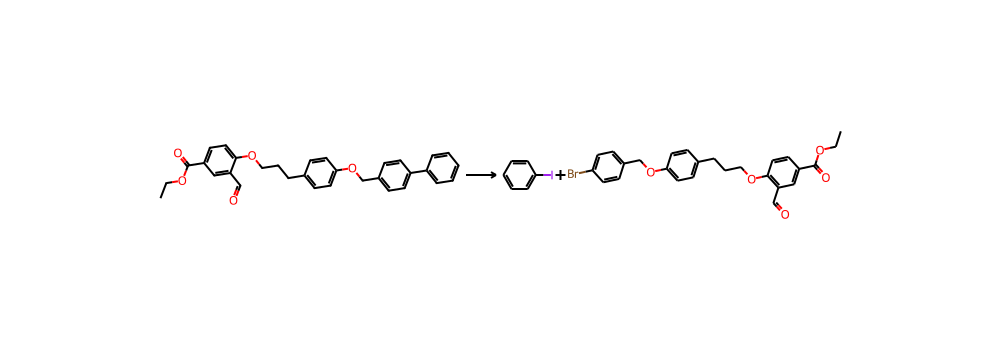

Sequence 1

Template Information (R2): US05470845__20
[4979C]:[8386C]([8386C](:[4979C]):[4979C]):[4979C]::0,1:1,5:2,3:2,4:


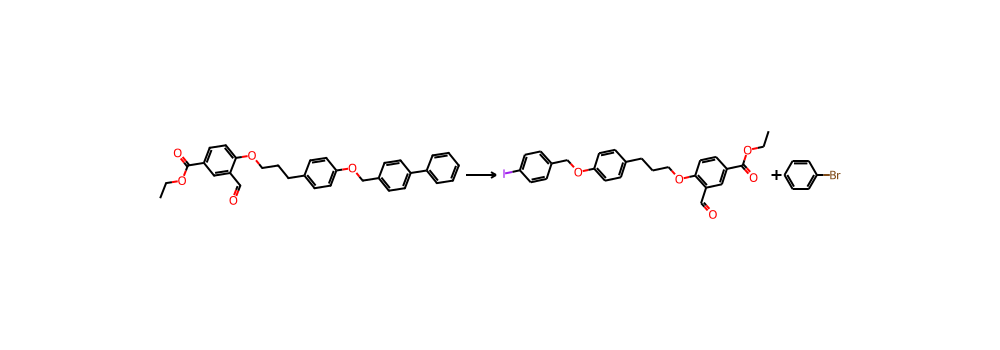

Sequence 2

Template Information (R2): US03985896__45
[4982C][13443O][7443C][4039C]


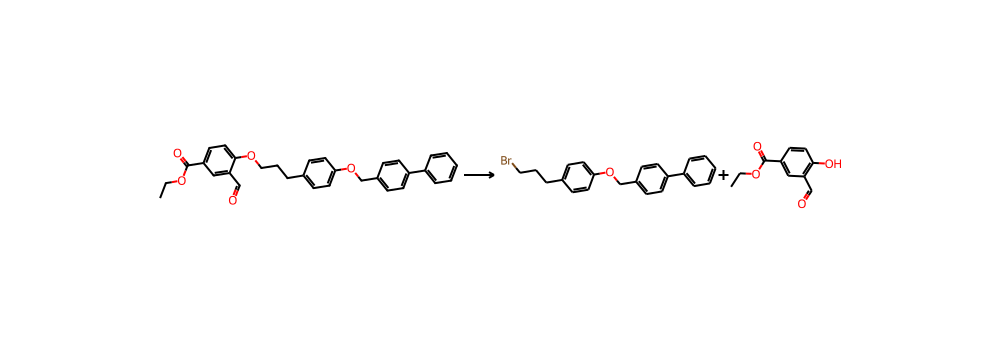

Sequence 3

Template Information (R2): US08232284B2__254
[4979C]:[8383C]:[4979C]::0,1:1,2:


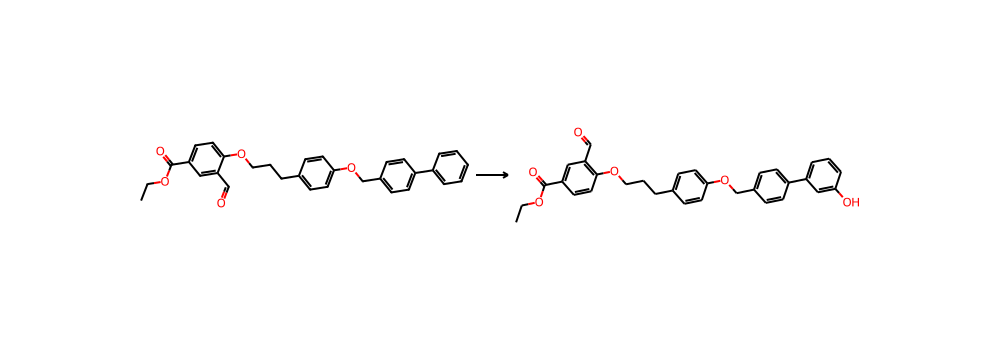

Sequence 4

Template Information (R2): US08232284B2__254
[4979C]:[8383C]:[4979C]::0,1:1,2:


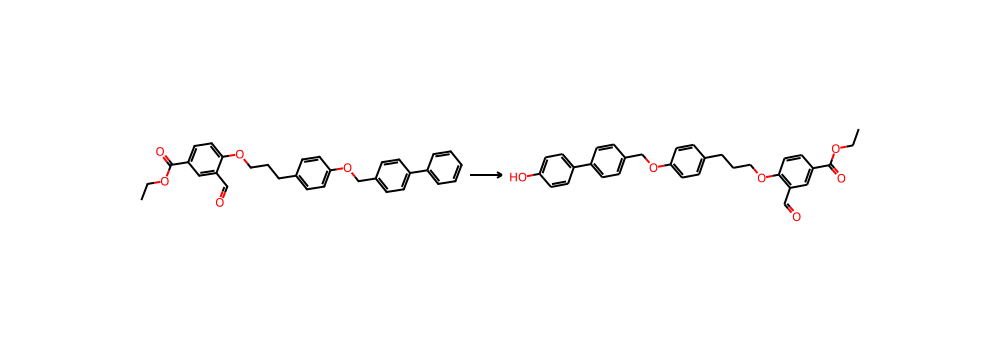

Sequence 5

Template Information (R2): US05298652__378
[4982C][13443O][7443C][4982C]


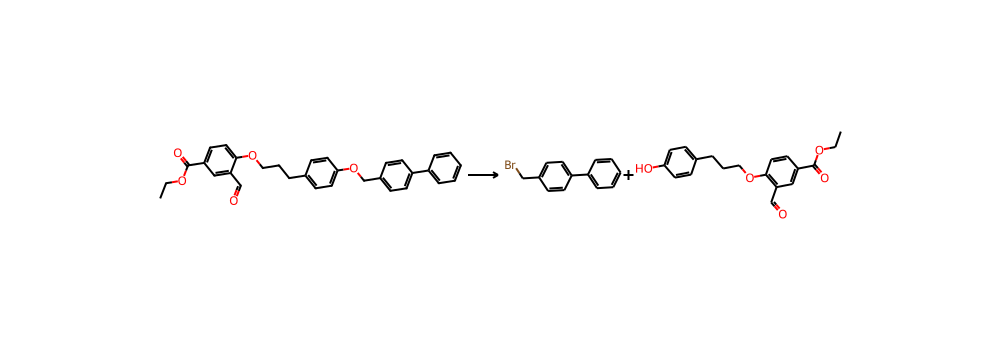

Sequence 6

Template Information (R2): US20110039852A1__969
[10035O]=[4043C][13443O][7443C][4034C]


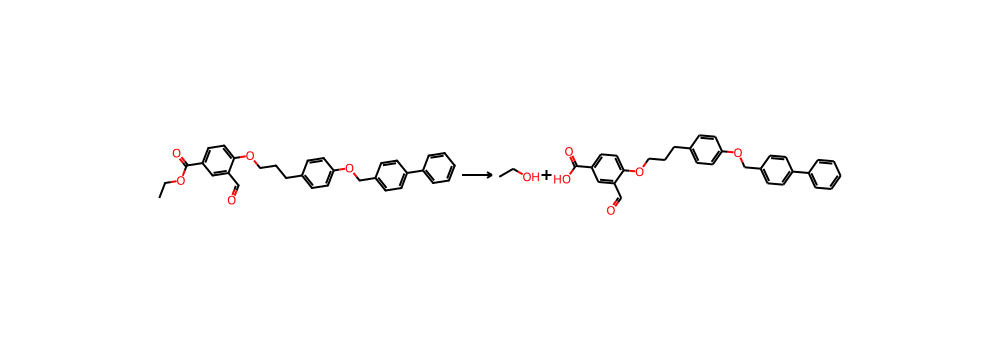

Sequence 7

Template Information (R2): US20070203205A1__1051
[4982C]:[8386C]([13443O][4039C]):[4979C]::0,1:1,4:


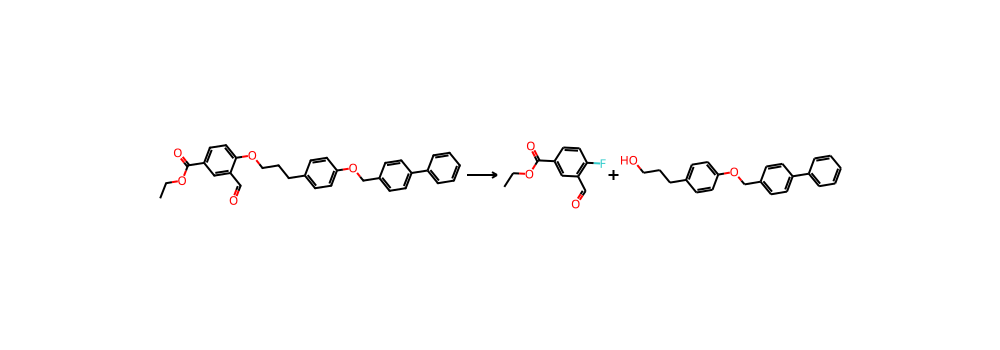

Sequence 8

Template Information (R2): US09157077B2__1082
[13439O]=[7444C][4982C]


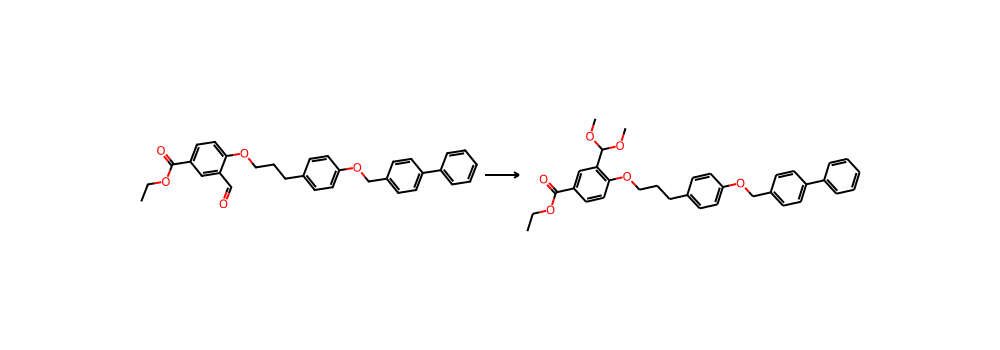

Sequence 9

Template Information (R2): US06720423B2__1896
[4982C][7443C][4039C]


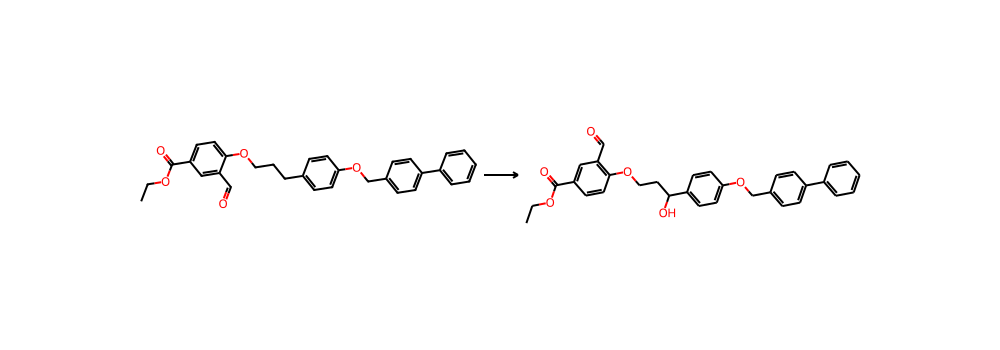

Sequence 10

Template Information (R2): US20080051405A1__2349
[4039C][13443O][8386C](:[4979C]):[4979C]::2,3:2,4:


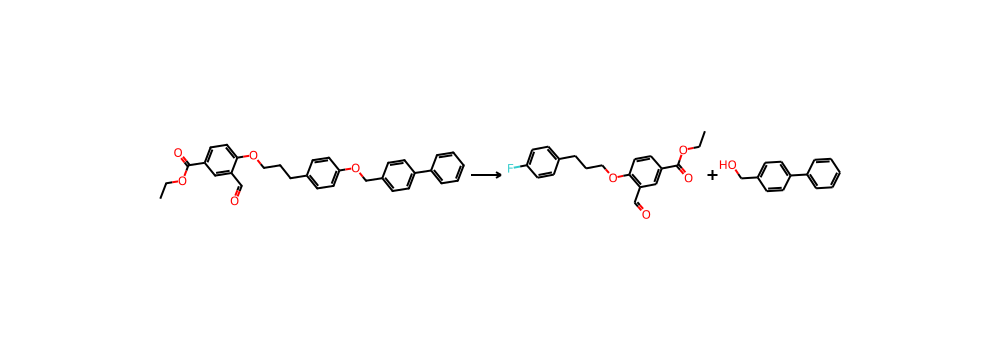

Sequence 11

Template Information (R2): US07999132B2__2665
[4982C][7443C][7443C][4039C]


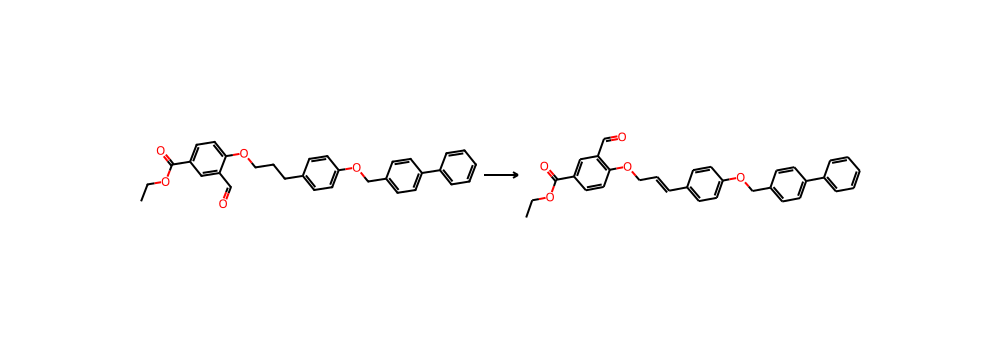

Sequence 12

Template Information (R2): USRE043632E1__3271
[10035O]=[7447C]([13443O][4039C])[4982C]


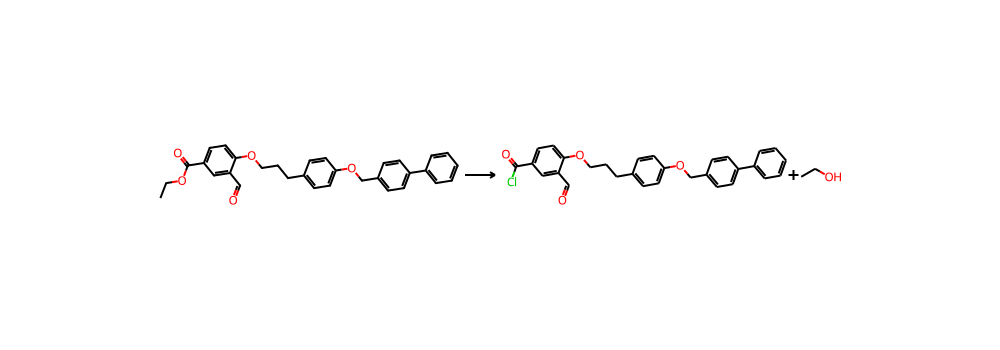

Sequence 13

Template Information (R2): US07674801B2__4785
[10035O]=[7444C][8386C](:[4982C]):[4979C]::2,3:2,4:


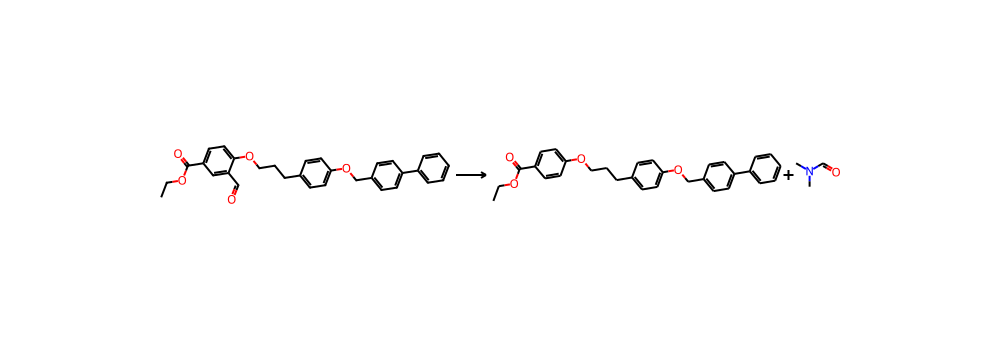

Sequence 14

Template Information (R2): US20130310331A1__5813
[4982C]:[8383C]:[4979C]::0,1:1,2:


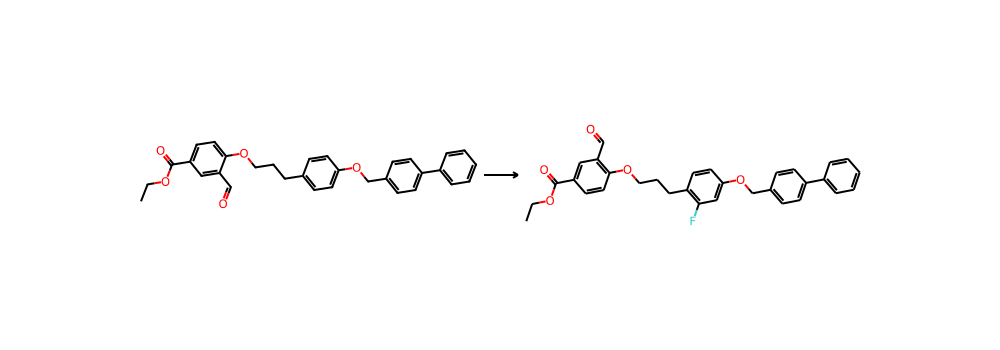

Sequence 15

Template Information (R2): US20130310331A1__5813
[4982C]:[8383C]:[4979C]::0,1:1,2:


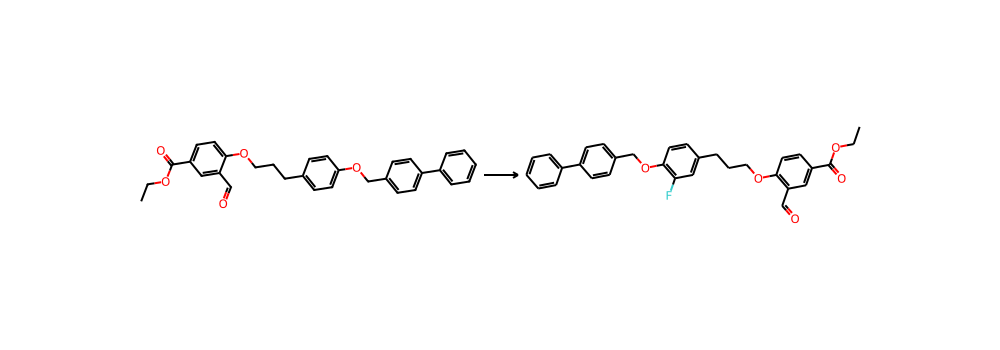

Sequence 16

Template Information (R2): US20130310331A1__5813
[4982C]:[8383C]:[4979C]::0,1:1,2:


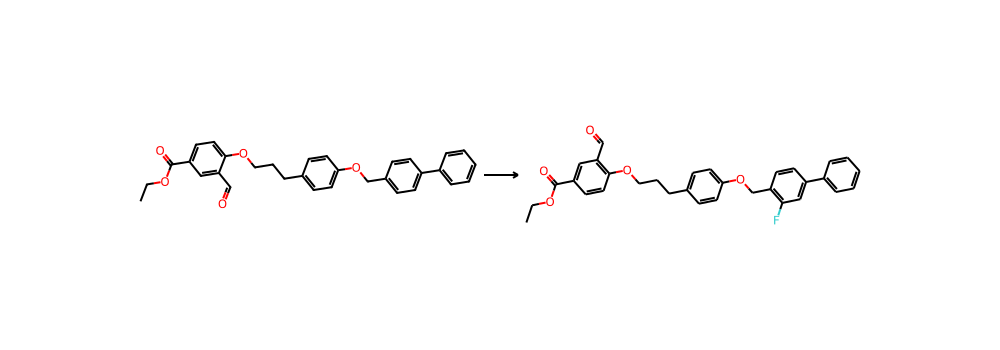

Sequence 17

Template Information (R2): US20130310331A1__5813
[4982C]:[8383C]:[4979C]::0,1:1,2:


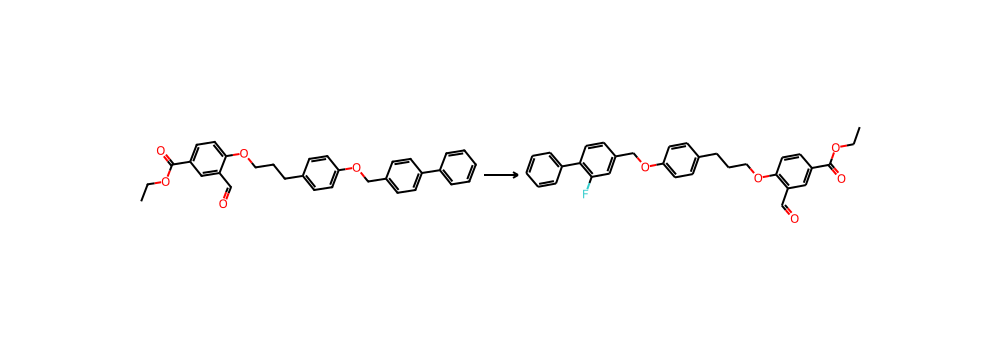

Sequence 18

Template Information (R2): US20130310331A1__5813
[4982C]:[8383C]:[4979C]::0,1:1,2:


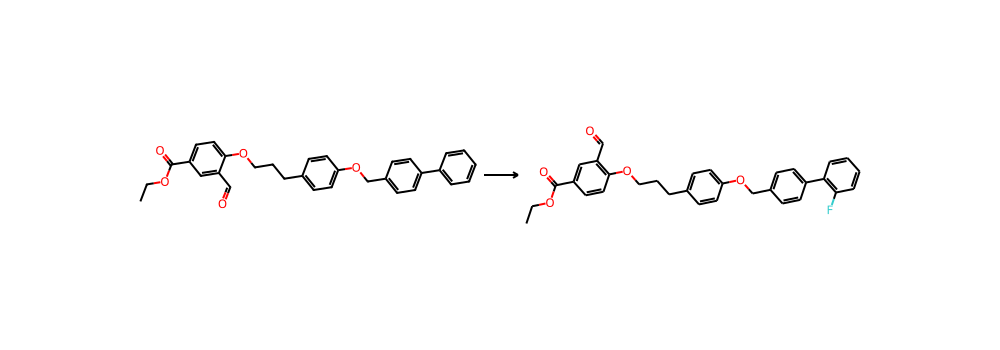

Sequence 19

Template Information (R2): US20130310331A1__5813
[4982C]:[8383C]:[4979C]::0,1:1,2:


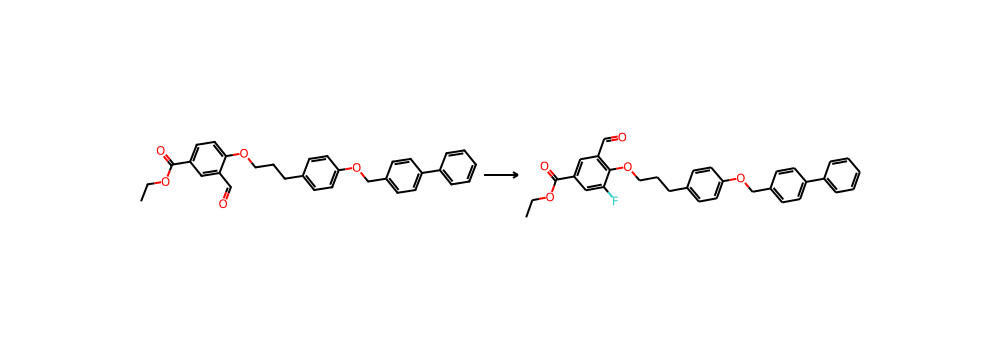

Sequence 20

Template Information (R2): US20130310331A1__5813
[4982C]:[8383C]:[4979C]::0,1:1,2:


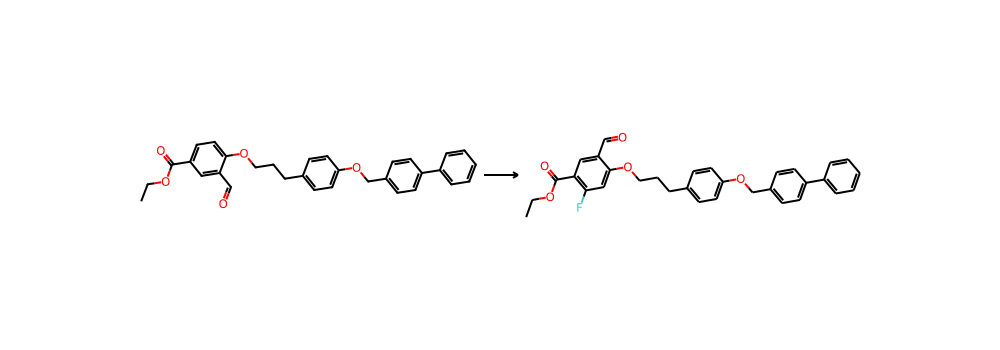

In [38]:
from rdkit import Chem
from rdkit.Chem import rdChemReactions
from rdkit.Chem import Draw
from rdkit.Chem.Draw import rdMolDraw2D
from IPython.display import SVG

for key, value in filtered_predictions.items():
    print(key, value["product"] +"\n")
    for idx, prediction in enumerate(value['predictions']):
        print("Sequence " + str(idx) +"\n")
        print("Template Information (R2): " + prediction["Template"] + "\n"+ prediction["Signature"])
        
        rxn_smiles = prediction["predicted_rxn_smi"]

        rxn = rdChemReactions.ReactionFromSmarts(rxn_smiles,useSmiles=True)
        rdChemReactions.SanitizeRxn(rxn)
        drawer = rdMolDraw2D.MolDraw2DSVG(1000,350)
        drawer.drawOptions().addStereoAnnotation = False
        drawer.DrawReaction(rxn,highlightByReactant=False)
        drawer.FinishDrawing()
        display(SVG(drawer.GetDrawingText()))

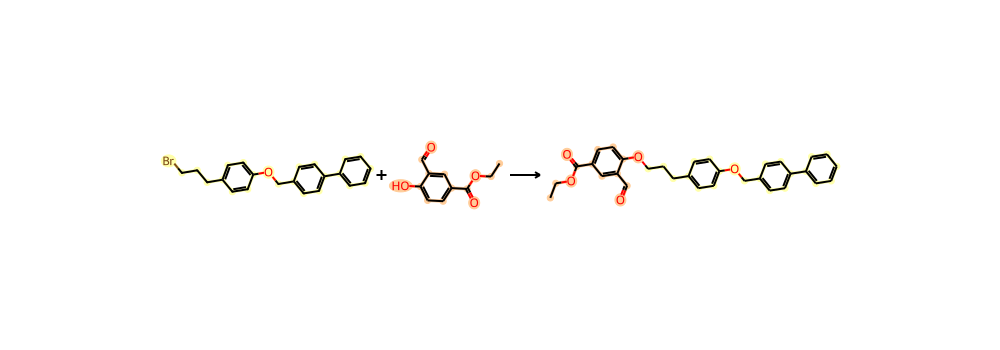

In [39]:
# Do any of the predictions match the ground truth (original test reaction)?
# Here is the ground truth rxn
with open("test_rxn.rsmi") as infile:
     line = infile.readline()
     ground_truth_smiles, id = line.split(' ')
rxn = rdChemReactions.ReactionFromSmarts(ground_truth_smiles,useSmiles=True)
rdChemReactions.SanitizeRxn(rxn)
drawer = rdMolDraw2D.MolDraw2DSVG(1000,350)
drawer.DrawReaction(rxn,highlightByReactant=True)
drawer.FinishDrawing()
display(SVG(drawer.GetDrawingText()))

In [40]:
# Get the reactants to test if a match
if ">>" in ground_truth_smiles:
   ground_truth_reactants, product = ground_truth_smiles.split(">>")
elif ">" in ground_truth_smiles:
   ground_truth_reactants, agents, product = ground_truth_smiles.split(">")

# remove atom maps and canonicalize
def remove_atom_mapping(smiles):
    """
    Remove atom mapping from smiles
    """
    mol = Chem.MolFromSmiles(smiles)
    for atom in mol.GetAtoms():
        atom.ClearProp('molAtomMapNumber')
    return Chem.MolToSmiles(mol)

canonical_ground_truth_reactants = remove_atom_mapping(ground_truth_reactants)
canonical_ground_truth_reactants

'BrCCCc1ccc(OCc2ccc(-c3ccccc3)cc2)cc1.CCOC(=O)c1ccc(O)c(C=O)c1'

In [41]:
# canonicalize prediction reactants with RDKit
from pprint import pprint
for key, value in filtered_predictions.items():
    for idx, prediction in enumerate(value['predictions']):
        prediction["canonical_rdkit_reactants"] = remove_atom_mapping(prediction["Reactants"])
        
       # check if it matches ground truth and print if True
        if prediction["canonical_rdkit_reactants"] == canonical_ground_truth_reactants:
           prediction["matches ground truth"] = True
           pprint("Sequence" + str(idx))
           pprint(value["predictions"][idx])
        else:
           prediction["matches ground truth"] = False

'Sequence2'
{'Reactants': 'BrCCCc1ccc(OCc2ccc(c3ccccc3)cc2)cc1.Oc1c(C=O)cc(C(=O)OCC)cc1',
 'Retro Type': 'ALL',
 'Signature': '[4982C][13443O][7443C][4039C]',
 'Template': 'US03985896__45',
 'canonical_rdkit_reactants': 'BrCCCc1ccc(OCc2ccc(-c3ccccc3)cc2)cc1.CCOC(=O)c1ccc(O)c(C=O)c1',
 'matches ground truth': True,
 'predicted_rxn_smi': 'C(CCC1=CC=C(OCC2=CC=C(C3=CC=CC=C3)C=C2)C=C1)OC1=CC=C(C(=O)OCC)C=C1C=O>>BrCCCc1ccc(OCc2ccc(c3ccccc3)cc2)cc1.Oc1c(C=O)cc(C(=O)OCC)cc1'}


## Run Retrosynthesis on testing data

In [42]:
# Now we will try retrosynthesis on the ~10,000 test products
# First is standardization
rxns_testing = []
with open("./temp/_rxns_testing.rsmi", "r") as infile:
    reader = csv.reader(infile, delimiter='\t')
    for idx,row in enumerate(reader):

        try:
            # generating new, unique id column   
            patentID = row[1] + "__" + str(idx)

            # cleaning additional symbols from rsmiles column (should remove any SMILES extensions after a space)
            rxnSmiles = row[0]
            if ' ' in rxnSmiles:
               cleaned_rxnSmiles = rxnSmiles.split(' ')[0]
               extensions = rxnSmiles.split(' ')[1]
            else:
               cleaned_rxnSmiles = rxnSmiles
               extensions = None
          
            rxns_testing.append((cleaned_rxnSmiles,patentID))
        except Exception as error:
            # skip bad line input
            continue

In [43]:
# Write to file
with open('./temp/_out_clean_testing.rsmi', 'w', newline='') as outfile:
    writer = csv.writer(outfile, delimiter=' ')
    for row in rxns_testing:
        writer.writerow(row)

In [44]:
# We'll do a similar standardization as the training data (Parts 1 and 2 combined here)
# Note that these reactions are not reversed

"""
Here is what the options mean:

-v, verbose
-c, discard chirality on input
-C 40, discard any reactions where the largest reagent has more than 40 atoms
-X igbad, discard bad reactions
-X rmdmap, discard reactions containing duplicate atom map numbers
-X nclf, discard reactions where there is no change in the largest fragment
-X rmiso, discard reactions containing isotopic atoms
-X rmmp, discard reactions that have multiple products

-D fmap, add unique mapping numbers for any atoms not mapped
-D rmdr, remove duplicate reactants
-D rmdp, remove duplicate products
-D rmda, remove duplicate agents
-D rmnmap, remove any component with no atom mapping at all
-D rmdup, remove components that are shown as both reactants and products

-s, reading reaction smiles
-K, fix alternating kekule issues
-E autocreate, automatically create new elements when encountered (e.g., R1 can be a valid element)

"""
fp = "./temp/"
std_testing = lillymol_path + "rxn_standardize -v -c -C40 -X igbad -X rmdmap -X nclf -X rmiso -X rmmp \
-D fmap -D rmdr -D rmdp -D rmda -D rmnmap -D rmdup -s -K -E autocreate " + fp + "_out_clean_testing.rsmi" + " > " + fp + "_std_out_testing.rsmi" + " 2>" + fp + "_std_out_testing.log\n"
subprocess.call([std_testing], shell=True)

0

In [45]:
# Split data into reactants, agents, and product
"""
reactants>agents>product    ID
reactants>>product  ID

"""

testing_reaction_data = []
with open("./temp/_std_out_testing.rsmi", 'r') as infile:
    for line in infile:
        if ">>" in line:
            rxn, id = line.split()
            reactants, product = rxn.split(">>")
            testing_reaction_data.append({
                'reactants': reactants,
                'product': product,
                'id': id
            })
            continue
        if ">" in line:
            rxn, id = line.split()
            reactants, agents, product = rxn.split(">")
            testing_reaction_data.append({
                'reactants': reactants,
                'agents': agents,
                'product': product,
                'id': id
            })
            continue

In [46]:
len(testing_reaction_data)

9035

In [47]:
testing_reaction_data[0]

{'reactants': '[CH2:38]1[CH2:39][CH2:40][O:41][CH2:42]1.[CH3:43][NH:44][C:45]1=[N:46][C:47](=[CH:52][CH:53]=[C:54]1[CH2:55][N:56]1[N:57]=[C:58]2[C:59](=[C:66]([C:67]3=[CH:68][CH:69]=[C:70]([Cl:71])[CH:72]=[CH:73]3)[CH:74]=[CH:75][N:76]2[C:77]1=[O:78])[C:60]1=[CH:61][CH:62]=[N:63][CH:64]=[CH:65]1)[C:48]([F:49])([F:50])[F:51].[Cl:79][C:1]1=[C:2]([CH2:3][N:4]2[C:5](=[O:6])[N:7]3[C:8](=[N:9]2)[C:10](=[C:17]([C:18]2=[CH:19][CH:20]=[C:21]([Cl:22])[CH:23]=[CH:24]2)[CH:25]=[CH:26]3)[C:11]2=[CH:12][CH:13]=[N:14][CH:15]=[CH:16]2)[CH:27]=[CH:28][C:29](=[N:34]1)[C:30]([F:31])([F:32])[F:33].[CH3:35][CH2:36][NH2:37]',
 'product': '[C:1]1(=[C:2]([CH2:3][N:4]2[C:5](=[O:6])[N:7]3[C:8](=[N:9]2)[C:10](=[C:17]([C:18]2=[CH:19][CH:20]=[C:21]([Cl:22])[CH:23]=[CH:24]2)[CH:25]=[CH:26]3)[C:11]2=[CH:12][CH:13]=[N:14][CH:15]=[CH:16]2)[CH:27]=[CH:28][C:29](=[N:34]1)[C:30]([F:31])([F:32])[F:33])[NH:37][CH2:36][CH3:35]',
 'id': 'US07572808B2__0'}

In [48]:
# write products to a file
with open("_testing_product_smiles.smi", 'w') as outfile:
    for item in testing_reaction_data:
        outfile.write(item['product'] + ' ' + item['id'] + '\n')

In [49]:
# Now run retrosynthesis, this will test each product against the list of templates in RRT_T10
retro = lillymol_path + "retrosynthesis -Z -z -Y all -X rmiso -X kg -X kekule -X ersfrm " \
     + "-a 2 -q f -v -R 1 -I _RRT_T10 -P UST:AZUCORS _testing_product_smiles.smi > _prediction_all.rsmi 2> _prediction_all.log"
subprocess.call([retro], shell=True)

0

In [50]:
"""
dictionary = {
    "parent_id": {
        "product": "",
        "predictions": [
            {
                "Reactants": ""
                "Template": "US05874436__5947"
                "Retro Type": "ALL" or "SPFRM.1" or "SPFRM.0"
            }
        ]
}
"""

# parse prediction data into a dictionary
predictions_testing = {}
with open("_prediction_all.rsmi", 'r') as infile:
    for line in infile:
        prediction_data = line.strip().split()
        if prediction_data[-1] == "PARENT":
            product = prediction_data[0]
            parent_id = prediction_data[1]
            if parent_id not in predictions_testing:

                predictions_testing[parent_id] = {
                    "product": product,
                    "predictions": []
                }
            continue


        if prediction_data[-1] != "PARENT": #, "SPFRM.1", "SPFRM.0"]:
            reactants = prediction_data[0]
            parent_id = prediction_data[1]
            retro_type = prediction_data[-1]
            template = prediction_data[3]
            signature = prediction_data[4]
            predictions_testing[parent_id]["predictions"].append({
                "Reactants": reactants,
                "Template": template,
                "Signature": signature,
                "Retro Type": retro_type
            })

In [51]:
# Filter for retro type ALL
filtered_predictions_all = {
    key: {
        'product': value['product'],
        'predictions': [pred for pred in value['predictions'] if pred['Retro Type'] == 'ALL'],
        'count': sum(1 for pred in value['predictions'] if pred['Retro Type'] == 'ALL')
    }
    for key, value in predictions_testing.items()
}

In [52]:
# Add reaction syntax
# Create rxn syntax for predictions
for key,value in filtered_predictions_all.items():
    product = value['product']
    for prediction in value['predictions']:
        rxn = product + ">>" + prediction["Reactants"] 
        prediction["predicted_rxn_smi"] = rxn

In [53]:
list(filtered_predictions_all.items())[0]

('US07572808B2__0',
 {'product': 'C1(=C(CN2C(=O)N3C(=N2)C(=C(C2=CC=C(Cl)C=C2)C=C3)C2=CC=NC=C2)C=CC(=N1)C(F)(F)F)NCC',
  'predictions': [{'Reactants': 'Brc1c(c2[n](c(=O)[n]([n]2)Cc2c(NCC)[n]c(C(F)(F)F)cc2)cc1)c1cc[n]cc1.Clc1ccc(B2OC(C(O2)(C)C)(C)C)cc1',
    'Template': 'US08071588B2__6',
    'Signature': '[4982C]:[8386C]([8386C](:[4979C]):[4979C]):[4979C]::0,1:1,5:2,3:2,4:',
    'Retro Type': 'ALL',
    'predicted_rxn_smi': 'C1(=C(CN2C(=O)N3C(=N2)C(=C(C2=CC=C(Cl)C=C2)C=C3)C2=CC=NC=C2)C=CC(=N1)C(F)(F)F)NCC>>Brc1c(c2[n](c(=O)[n]([n]2)Cc2c(NCC)[n]c(C(F)(F)F)cc2)cc1)c1cc[n]cc1.Clc1ccc(B2OC(C(O2)(C)C)(C)C)cc1'},
   {'Reactants': 'O=c1[n]2c([n][nH]1)c(c1cc[n]cc1)c(cc2)c1ccc(Cl)cc1.CCNc1c(CCl)ccc(C(F)(F)F)[n]1',
    'Template': 'US05196425__1408',
    'Signature': '[7912N]:[11318N]([7443C][4982C]):[4909C]::0,1:1,4:',
    'Retro Type': 'ALL',
    'predicted_rxn_smi': 'C1(=C(CN2C(=O)N3C(=N2)C(=C(C2=CC=C(Cl)C=C2)C=C3)C2=CC=NC=C2)C=CC(=N1)C(F)(F)F)NCC>>O=c1[n]2c([n][nH]1)c(c1cc[n]cc1)c(cc2)c1ccc(C

In [54]:
# Get top 10 (with many predictions)
# top_10 = dict(sorted(filtered_predictions_all.items(), key=lambda item: item[1]['count'], reverse=True)[:10])
# top_10

In [55]:
# count of predictions for each target
total_sum = 0
for key, value in filtered_predictions_all.items():
    total_sum += value["count"]
print(total_sum)

61505


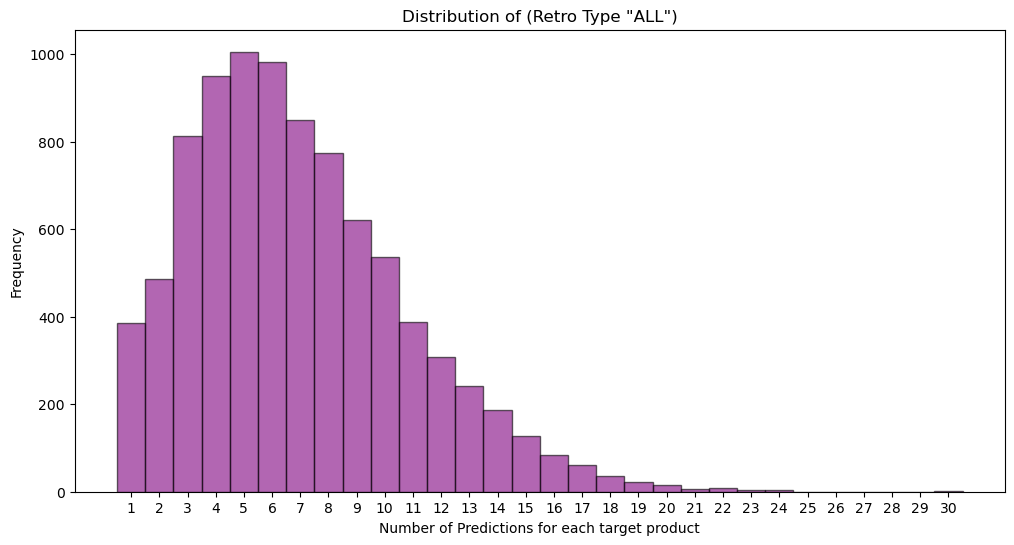

In [56]:
# show distribution of counts
import matplotlib.pyplot as plt

# Extract counts
counts = [value['count'] for value in filtered_predictions_all.values()]

# Plot the histogram
fig, ax = plt.subplots(figsize=(12, 6)) 
plt.hist(counts, bins=range(1, max(counts) + 2), edgecolor='black', align='left', color='purple', alpha=0.6)
plt.xlabel('Number of Predictions for each target product')
plt.ylabel('Frequency')
plt.title('Distribution of (Retro Type "ALL")')
plt.xticks(range(1, max(counts) + 1))
plt.show()

## Compare Predictions to Ground Truth

This is just for curiosity, it was not included in the original paper. It's possible this is not as relevent to the LillyMol method, more research needed on that...

In [57]:
# "ground_truth" is referring to the standardized reaction from the test data.
# So an important note is that they are not the exact original reactions from the patent data
# as they have been put through our standardization workflow. - We also remove atom mapping first, 
# and then compare canonical smiles of predicted vs. ground truth

ground_truths = {}
with open("./temp/_std_out_testing.rsmi", 'r') as infile:
    for line in infile:
        split_data = line.split()
        if len(split_data) == 2:
            rxn, id = split_data
            ground_truths[id] = rxn

len(ground_truths)

9035

In [58]:
list(ground_truths.items())[0]

('US07572808B2__0',
 '[CH2:38]1[CH2:39][CH2:40][O:41][CH2:42]1.[CH3:43][NH:44][C:45]1=[N:46][C:47](=[CH:52][CH:53]=[C:54]1[CH2:55][N:56]1[N:57]=[C:58]2[C:59](=[C:66]([C:67]3=[CH:68][CH:69]=[C:70]([Cl:71])[CH:72]=[CH:73]3)[CH:74]=[CH:75][N:76]2[C:77]1=[O:78])[C:60]1=[CH:61][CH:62]=[N:63][CH:64]=[CH:65]1)[C:48]([F:49])([F:50])[F:51].[Cl:79][C:1]1=[C:2]([CH2:3][N:4]2[C:5](=[O:6])[N:7]3[C:8](=[N:9]2)[C:10](=[C:17]([C:18]2=[CH:19][CH:20]=[C:21]([Cl:22])[CH:23]=[CH:24]2)[CH:25]=[CH:26]3)[C:11]2=[CH:12][CH:13]=[N:14][CH:15]=[CH:16]2)[CH:27]=[CH:28][C:29](=[N:34]1)[C:30]([F:31])([F:32])[F:33].[CH3:35][CH2:36][NH2:37]>>[C:1]1(=[C:2]([CH2:3][N:4]2[C:5](=[O:6])[N:7]3[C:8](=[N:9]2)[C:10](=[C:17]([C:18]2=[CH:19][CH:20]=[C:21]([Cl:22])[CH:23]=[CH:24]2)[CH:25]=[CH:26]3)[C:11]2=[CH:12][CH:13]=[N:14][CH:15]=[CH:16]2)[CH:27]=[CH:28][C:29](=[N:34]1)[C:30]([F:31])([F:32])[F:33])[NH:37][CH2:36][CH3:35]')

In [59]:
# Get number of targets that have at least one prediction
count = 0
for parent_id, data in filtered_predictions_all.items():
    if parent_id in ground_truths:
        count+=1
print(count)

8899


In [60]:
# Some targets have multiple predictions
total_predictions = 0
for parent_id, data in filtered_predictions_all.items():
    total_predictions += len(data['predictions'])
total_predictions

61505

In [61]:
# function to remove atom maps and canonicalize
def remove_atom_mapping(smiles):
    """
    Remove atom mapping from smiles
    """
    mol = Chem.MolFromSmiles(smiles)
    for atom in mol.GetAtoms():
        atom.ClearProp('molAtomMapNumber')
    return Chem.MolToSmiles(mol)

In [62]:
list(filtered_predictions_all.items())[0]

('US07572808B2__0',
 {'product': 'C1(=C(CN2C(=O)N3C(=N2)C(=C(C2=CC=C(Cl)C=C2)C=C3)C2=CC=NC=C2)C=CC(=N1)C(F)(F)F)NCC',
  'predictions': [{'Reactants': 'Brc1c(c2[n](c(=O)[n]([n]2)Cc2c(NCC)[n]c(C(F)(F)F)cc2)cc1)c1cc[n]cc1.Clc1ccc(B2OC(C(O2)(C)C)(C)C)cc1',
    'Template': 'US08071588B2__6',
    'Signature': '[4982C]:[8386C]([8386C](:[4979C]):[4979C]):[4979C]::0,1:1,5:2,3:2,4:',
    'Retro Type': 'ALL',
    'predicted_rxn_smi': 'C1(=C(CN2C(=O)N3C(=N2)C(=C(C2=CC=C(Cl)C=C2)C=C3)C2=CC=NC=C2)C=CC(=N1)C(F)(F)F)NCC>>Brc1c(c2[n](c(=O)[n]([n]2)Cc2c(NCC)[n]c(C(F)(F)F)cc2)cc1)c1cc[n]cc1.Clc1ccc(B2OC(C(O2)(C)C)(C)C)cc1'},
   {'Reactants': 'O=c1[n]2c([n][nH]1)c(c1cc[n]cc1)c(cc2)c1ccc(Cl)cc1.CCNc1c(CCl)ccc(C(F)(F)F)[n]1',
    'Template': 'US05196425__1408',
    'Signature': '[7912N]:[11318N]([7443C][4982C]):[4909C]::0,1:1,4:',
    'Retro Type': 'ALL',
    'predicted_rxn_smi': 'C1(=C(CN2C(=O)N3C(=N2)C(=C(C2=CC=C(Cl)C=C2)C=C3)C2=CC=NC=C2)C=CC(=N1)C(F)(F)F)NCC>>O=c1[n]2c([n][nH]1)c(c1cc[n]cc1)c(cc2)c1ccc(C

In [63]:
from rdkit import RDLogger
RDLogger.DisableLog('rdApp.*')


# compare ground truth reactants to predicted reactants to see if they are the same
for parent_id, data in filtered_predictions_all.items():
    target = data['product']
    for prediction in data['predictions']:
        reactants = prediction['Reactants']
        template_id = prediction['Template']

        # Check if predicted reactants are the same as the ground truth

        if parent_id not in ground_truths:
            prediction["matches ground truth"] = False
            continue
        ground_truth = ground_truths[parent_id]
        ground_truth_reactants = None
        if ">>" in ground_truth:
            ground_truth_reactants = ground_truth.split(">>")[0]
        elif ">" in ground_truth:
            ground_truth_reactants = ground_truth.split(">")[0]

        # canonicalize the smiles
        try:
            canonical_predicted_reactants = remove_atom_mapping(reactants)
        except Exception as e:
            prediction["matches ground truth"] = "Could not canonicalize predicted reactants"
            continue
        try:
            canonical_ground_truth_reactants = remove_atom_mapping(ground_truth_reactants)
        except Exception as e:
            prediction["matches ground truth"] = "Could not canonicalize ground truth"
            continue

        prediction["matches ground truth"] = canonical_predicted_reactants == canonical_ground_truth_reactants
        prediction["canonical_predicted_reactants"] = canonical_predicted_reactants
        prediction["canonical_ground_truth_reactants"] = canonical_ground_truth_reactants

In [64]:
list(filtered_predictions_all.items())[0]

('US07572808B2__0',
 {'product': 'C1(=C(CN2C(=O)N3C(=N2)C(=C(C2=CC=C(Cl)C=C2)C=C3)C2=CC=NC=C2)C=CC(=N1)C(F)(F)F)NCC',
  'predictions': [{'Reactants': 'Brc1c(c2[n](c(=O)[n]([n]2)Cc2c(NCC)[n]c(C(F)(F)F)cc2)cc1)c1cc[n]cc1.Clc1ccc(B2OC(C(O2)(C)C)(C)C)cc1',
    'Template': 'US08071588B2__6',
    'Signature': '[4982C]:[8386C]([8386C](:[4979C]):[4979C]):[4979C]::0,1:1,5:2,3:2,4:',
    'Retro Type': 'ALL',
    'predicted_rxn_smi': 'C1(=C(CN2C(=O)N3C(=N2)C(=C(C2=CC=C(Cl)C=C2)C=C3)C2=CC=NC=C2)C=CC(=N1)C(F)(F)F)NCC>>Brc1c(c2[n](c(=O)[n]([n]2)Cc2c(NCC)[n]c(C(F)(F)F)cc2)cc1)c1cc[n]cc1.Clc1ccc(B2OC(C(O2)(C)C)(C)C)cc1',
    'matches ground truth': False,
    'canonical_predicted_reactants': 'CC1(C)OB(c2ccc(Cl)cc2)OC1(C)C.CCNc1nc(C(F)(F)F)ccc1Cn1nc2c(-c3ccncc3)c(Br)ccn2c1=O',
    'canonical_ground_truth_reactants': 'C1CCOC1.CCN.CNc1nc(C(F)(F)F)ccc1Cn1nc2c(-c3ccncc3)c(-c3ccc(Cl)cc3)ccn2c1=O.O=c1n(Cc2ccc(C(F)(F)F)nc2Cl)nc2c(-c3ccncc3)c(-c3ccc(Cl)cc3)ccn12'},
   {'Reactants': 'O=c1[n]2c([n][nH]1)c(c1cc[n

In [65]:
# How many predictions match ground truth?
# Note this does not mean that non-matches are incorrect predictions, they just don't match the original "ground truth" rxn...
match = 0
for key, value in filtered_predictions_all.items():
    for prediction in value['predictions']:
        if prediction['matches ground truth']:
            match += 1
print(f"Number of matches: {match}")

Number of matches: 1446


## Precedent Reactions for Reference

Something interesting we can do mentioned in ref [3] is to look at the precedent reactions associated with a prediction sequence (a cluster of rxns associated with a unique signature).

In [66]:
# We have a dictionary of the filtered signatures
# We can get all precedent reactions (from training) associated with a particular signature.
list(filtered_sig_count.items())[0:5]

[('[4982C][10449N][8348C]([4941C])[4941C]::2,3:2,4:', 22),
 ('[13438O][7446C]([4982C])[4039C]', 55),
 ('[13438O][4043C]=[10035O]', 2693),
 ('[13438O][7446C]([4909C])[4034C]', 10),
 ('[4795C][11205N][4795C]::0,1:1,2:', 38)]

In [67]:
print(len(filtered_sig_count))

596


In [68]:
# Let's load the signature file again and merge with the associated standardized SMILES

signatures = []
with open("_out_sig", 'r') as infile:
    for line in infile:
        split_data = line.split()
        if len(split_data) == 6:
            sigrsmi, na, id, sigr0, sigr1, sigr2 = split_data
            signatures.append({
                'sigrsmi': sigrsmi,
                'na': na,
                'id': id,
                'sigr0': sigr0,
                'sigr1': sigr1,
                'sigr2': sigr2
            })

# pull out data from `out_rstd` file and merge with cdf to get data
with open("_out_rstd", 'r') as infile:
    for line in infile:
        split_data = line.split()
        if len(split_data) == 2:
            stdrsmi, id = split_data
            for item in signatures:
                if item['id'] == id:
                    item['stdrsmi'] = stdrsmi
                    break

In [69]:
# Get the precedent rxns by signature
precedent_rxns = {}
for item in signatures:
    signature = item[radius]
    for sig,value in filtered_sig_count.items():
        if sig == signature:
            if sig not in precedent_rxns:
               precedent_rxns[sig] = {'count': value, 'reactions':[]}
            precedent_rxns[sig]['reactions'].append({'id': item['id'], 'stdrsmi': item['stdrsmi']})   

In [70]:
list(precedent_rxns.items())[0]

('[4982C][10449N][8348C]([4941C])[4941C]::2,3:2,4:',
 {'count': 22,
  'reactions': [{'id': 'US20080090806A1__0',
    'stdrsmi': '[CH:1]1([NH:21][C:20]2=[C:15]([NH2:14])[CH:16]=[CH:17][N:18]=[CH:19]2)[CH2:2][CH2:3][N:4]([CH2:5][C:6]2=[CH:7][CH:8]=[CH:9][CH:10]=[CH:11]2)[CH2:12][CH2:13]1>>[CH3:22][C:23](=[O:24])[OH:25]+[CH3:26][CH:27]([Cl:28])[Cl:29]+[O:30]=[C:1]1[CH2:2][CH2:3][N:4]([CH2:5][C:6]2=[CH:7][CH:8]=[CH:9][CH:10]=[CH:11]2)[CH2:12][CH2:13]1+[NH2:14][C:15]1=[C:20]([NH2:21])[CH:19]=[N:18][CH:17]=[CH:16]1'},
   {'id': 'US20050203087A1__401',
    'stdrsmi': '[CH:1]1([NH:30][C:29]2=[CH:28][CH:27]=[C:26]([C:25]3=[C:33]([Br:34])[C:18](=[C:19]([S:24]3)[C:20](=[O:21])[O:22][CH3:23])[O:17][CH2:16][C:14](=[O:15])[O:13][CH2:12][CH3:11])[CH:32]=[CH:31]2)[CH2:2][C:3]([CH3:4])([CH3:5])[CH2:6][C:7]([CH3:8])([CH3:9])[CH2:10]1>>[CH3:35][C:36](=[O:37])[OH:38]+[CH3:39][C:40](=[O:41])[O:42][BH-:43]([O:44][C:45]([CH3:46])=[O:47])[O:48][C:49]([CH3:50])=[O:51]+[O:52]=[C:1]1[CH2:2][C:3]([CH3:4])([CH3:5]

In [71]:
total_precedent_rxns = 0
for sig, data in precedent_rxns.items():
    total_precedent_rxns += len(data['reactions'])
total_precedent_rxns

27714

In [72]:
# Now let's go back to our filtered_predictions_all
# and look at an example

ID = "US09079866B2__6" # target mol ID
filtered_predictions_all[ID]

{'product': 'C1(=C(S(=O)(=O)C2=CC=CC=C2)C=CC=C1)C1=CC=C(C2=CN=C(N)C=N2)C(F)=C1',
 'predictions': [{'Reactants': 'Brc1c(S(=O)(=O)c2ccccc2)cccc1.Fc1c(c2[n]cc(N)[n]c2)ccc(B2OC(C(O2)(C)C)(C)C)c1',
   'Template': 'US08071588B2__6',
   'Signature': '[4982C]:[8386C]([8386C](:[4979C]):[4979C]):[4979C]::0,1:1,5:2,3:2,4:',
   'Retro Type': 'ALL',
   'predicted_rxn_smi': 'C1(=C(S(=O)(=O)C2=CC=CC=C2)C=CC=C1)C1=CC=C(C2=CN=C(N)C=N2)C(F)=C1>>Brc1c(S(=O)(=O)c2ccccc2)cccc1.Fc1c(c2[n]cc(N)[n]c2)ccc(B2OC(C(O2)(C)C)(C)C)c1',
   'matches ground truth': True,
   'canonical_predicted_reactants': 'CC1(C)OB(c2ccc(-c3cnc(N)cn3)c(F)c2)OC1(C)C.O=S(=O)(c1ccccc1)c1ccccc1Br',
   'canonical_ground_truth_reactants': 'CC1(C)OB(c2ccc(-c3cnc(N)cn3)c(F)c2)OC1(C)C.O=S(=O)(c1ccccc1)c1ccccc1Br'},
  {'Reactants': 'Fc1c(c2[n]cc([N+](=O)[O-])[n]c2)ccc(c1)c1c(S(=O)(=O)c2ccccc2)cccc1',
   'Template': 'US20100204196A1__32',
   'Signature': '[10444N][4982C]',
   'Retro Type': 'ALL',
   'predicted_rxn_smi': 'C1(=C(S(=O)(=O)C2=CC=CC=

In [73]:
# first prediction
seq0_smiles = filtered_predictions_all[ID]["predictions"][0]["predicted_rxn_smi"]
seq0_smiles

'C1(=C(S(=O)(=O)C2=CC=CC=C2)C=CC=C1)C1=CC=C(C2=CN=C(N)C=N2)C(F)=C1>>Brc1c(S(=O)(=O)c2ccccc2)cccc1.Fc1c(c2[n]cc(N)[n]c2)ccc(B2OC(C(O2)(C)C)(C)C)c1'

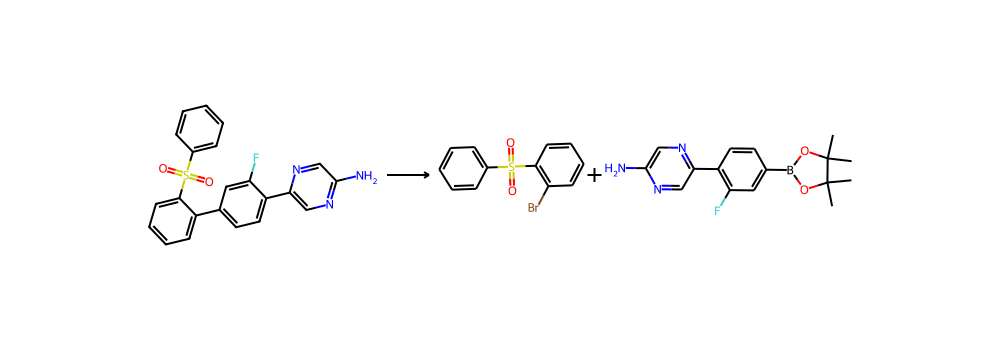

In [74]:
# Look at first predicted reaction
rxn = rdChemReactions.ReactionFromSmarts(seq0_smiles,useSmiles=True)
rdChemReactions.SanitizeRxn(rxn)
drawer = rdMolDraw2D.MolDraw2DSVG(1000,350)
drawer.drawOptions().addStereoAnnotation = False
drawer.DrawReaction(rxn,highlightByReactant=False)
drawer.FinishDrawing()
display(SVG(drawer.GetDrawingText()))

In [75]:
# Get the signature used
seq0_signature = filtered_predictions_all[ID]["predictions"][0]["Signature"]
seq0_signature

'[4982C]:[8386C]([8386C](:[4979C]):[4979C]):[4979C]::0,1:1,5:2,3:2,4:'

In [76]:
# Now get the list of precedent reactions associated with this signature
# We can get the precedent reactions like this:
Seq0_precedent_rxns = precedent_rxns[seq0_signature]

# number of precedent reactions
list(Seq0_precedent_rxns.items())[0]

('count', 320)

In [77]:
# We need to do a few things:

# 1. We need to convert the precedent reactions + component SMILES to .
# 2. We need a way to rank the reactions, we will use rdkit reaction fingerprints
#    to compare the predicted rxn to precedent reactions similarity

for reaction in Seq0_precedent_rxns["reactions"]:
    id = reaction['id']
    precedent_rxn_plus = reaction['stdrsmi']

    with open("_temp_plus_smiles", "w") as outfile:
        outfile.write(precedent_rxn_plus + "\n")
    # convert + to .    
    cmd = [lillymol_path+"rxn_standardize", "-d", "d", "-s", "_temp_plus_smiles"]
    try:
        # Run the command
        precident_reaction_period = subprocess.check_output(cmd, text=True)
        reaction["stdrsmi_periods"] = precident_reaction_period.strip()
    except subprocess.CalledProcessError as e:
            print(f"Error standardizing reaction: {e.output}")

In [78]:
# We will compare the precedent reactions to the sequence 0 prediction
from rdkit.Chem import AllChem
from rdkit.Chem import rdChemReactions

from rdkit import RDLogger
RDLogger.DisableLog('rdApp.*')

Seq0_predicted_smiles = filtered_predictions_all[ID]["predictions"][0]["predicted_rxn_smi"]

for reaction in Seq0_precedent_rxns["reactions"]:
    id = reaction['id']
    precedent_smiles = reaction['stdrsmi_periods']

    # compute reaction similarity based on fingerprints
    # WARNING: I don't think mapping numbers matter
    # However, agents do influence rxn fingerprint, I'm leaving them out here
    # as the predicted reactions do not have agents

    # Set up ReactionFingerprintParams with includeAgents=False
    params = rdChemReactions.ReactionFingerprintParams()
    params.includeAgents = False  # Do not include agents
    params.fpSize = 2048          # Size of the fingerprint
    params.fpType = rdChemReactions.FingerprintType.AtomPairFP
    
    try:
        predicted_rxn = rdChemReactions.ReactionFromSmarts(Seq0_predicted_smiles, useSmiles=True)
        rdChemReactions.SanitizeRxn(predicted_rxn)

        precedent_rxn = rdChemReactions.ReactionFromSmarts(precedent_smiles, useSmiles=True)
        rdChemReactions.SanitizeRxn(precedent_rxn)

        # Calculate the difference fingerprint
        predicted_fp = rdChemReactions.CreateDifferenceFingerprintForReaction(predicted_rxn, params)
        precedent_fp = rdChemReactions.CreateDifferenceFingerprintForReaction(precedent_rxn, params)

        similarity = AllChem.DataStructs.TanimotoSimilarity(precedent_fp, predicted_fp)
        reaction["similarity"] = similarity
    except:
        reaction["similarity"] = -1 # failure

In [79]:
# sort by highest similarity
sorted_reactions = sorted(Seq0_precedent_rxns['reactions'], key=lambda x: x['similarity'], reverse=True)

# Updating the dictionary with the sorted reactions
Seq0_precedent_rxns['reactions'] = sorted_reactions

In [80]:
#Seq0_precedent_rxns

precedent reaction: US09079866B2__8407
similarity: 0.6406926406926406


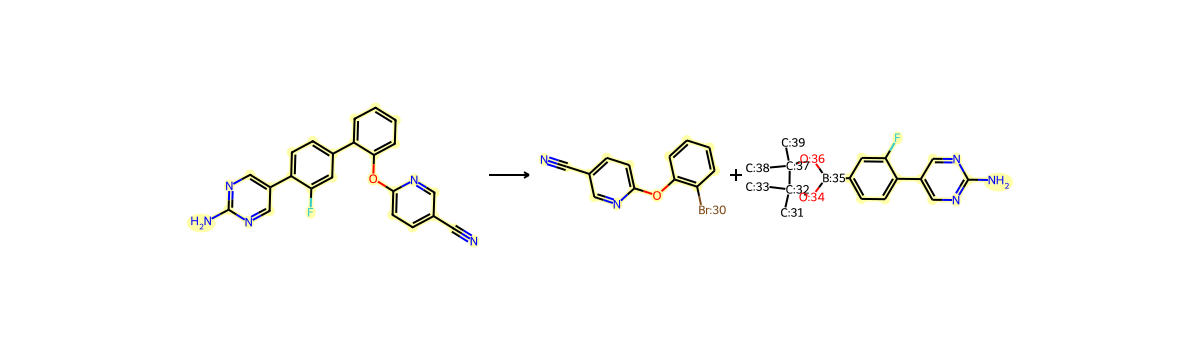

precedent reaction: US09079866B2__27823
similarity: 0.6231263383297645


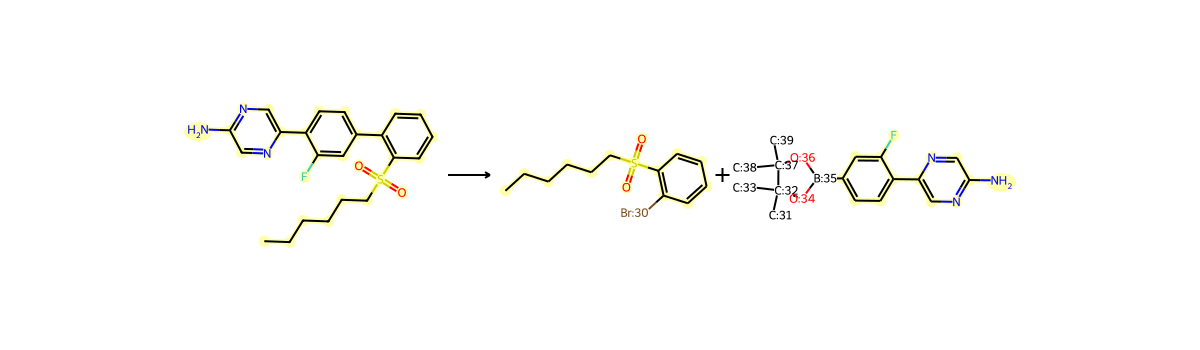

precedent reaction: US09079866B2__16637
similarity: 0.6022944550669216


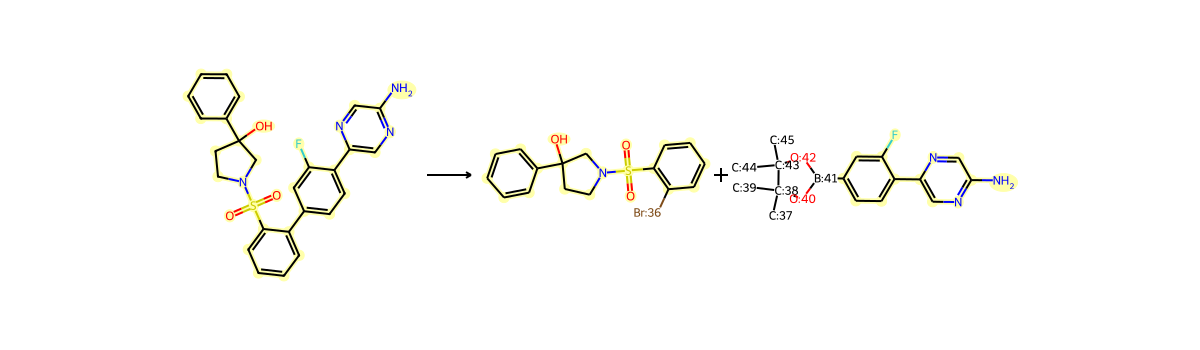

precedent reaction: US09079866B2__21091
similarity: 0.5850467289719626


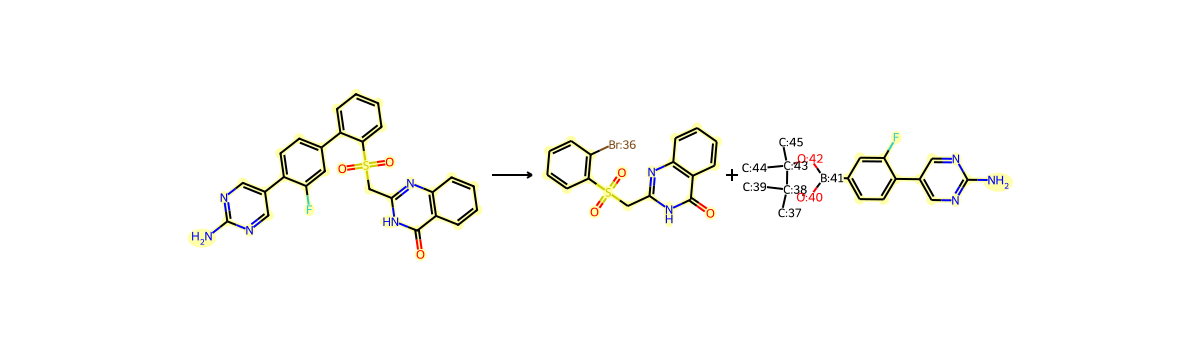

precedent reaction: US09079866B2__14418
similarity: 0.5623800383877159


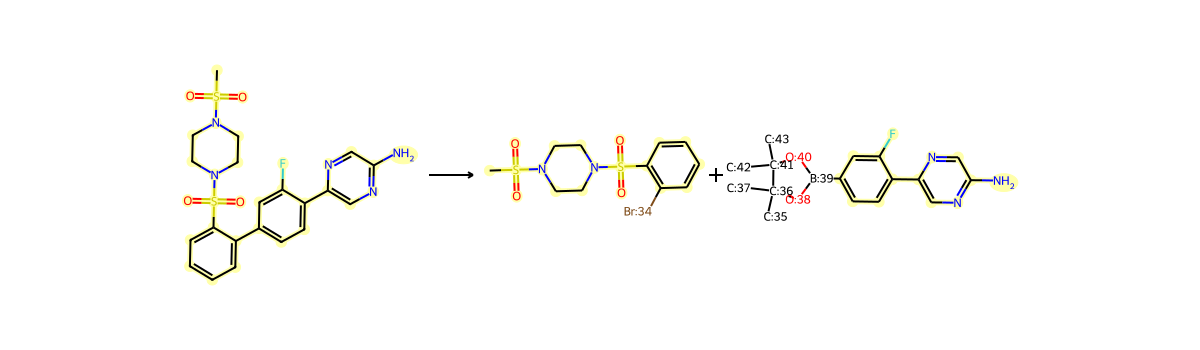

precedent reaction: US09079866B2__37918
similarity: 0.532803180914513


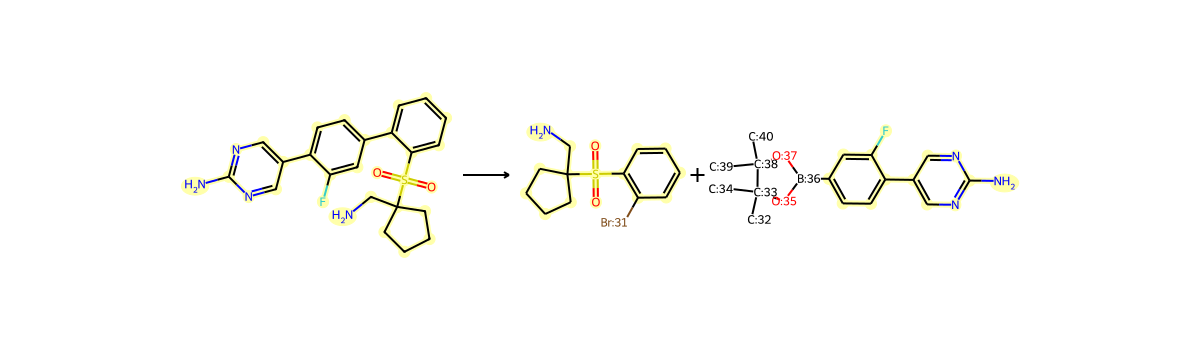

precedent reaction: US09079866B2__18620
similarity: 0.5255905511811023


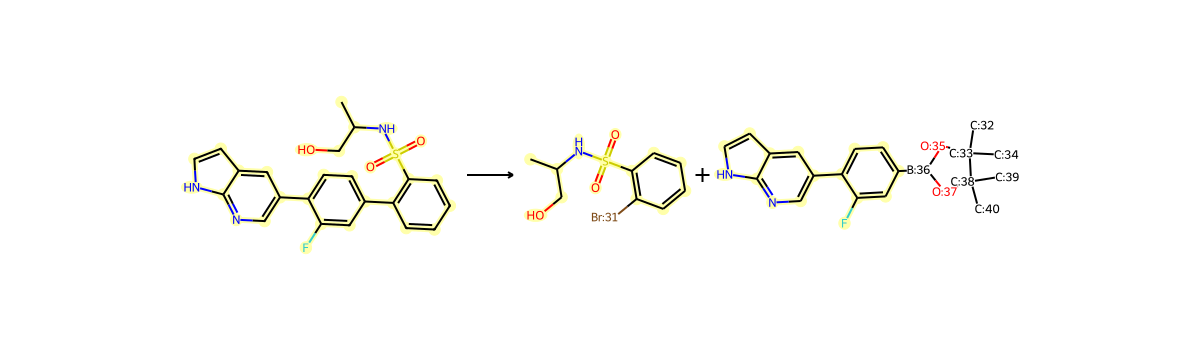

precedent reaction: US09079866B2__38843
similarity: 0.5217391304347826


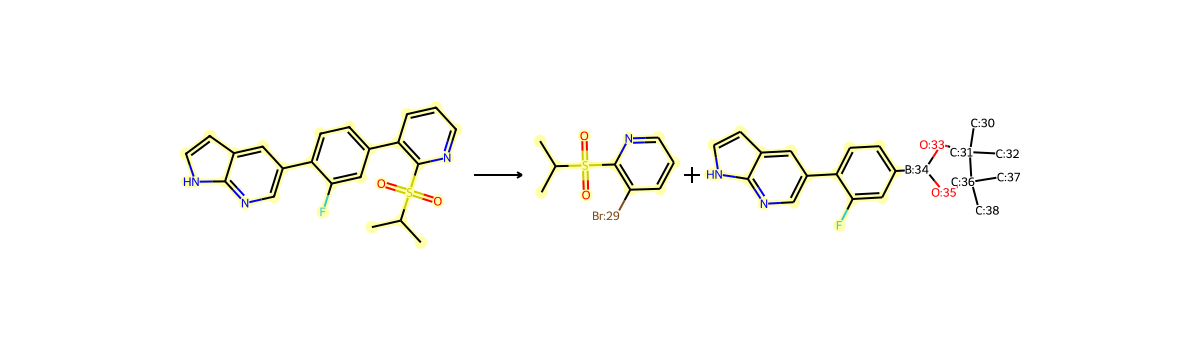

precedent reaction: US09079866B2__5662
similarity: 0.4749568221070812


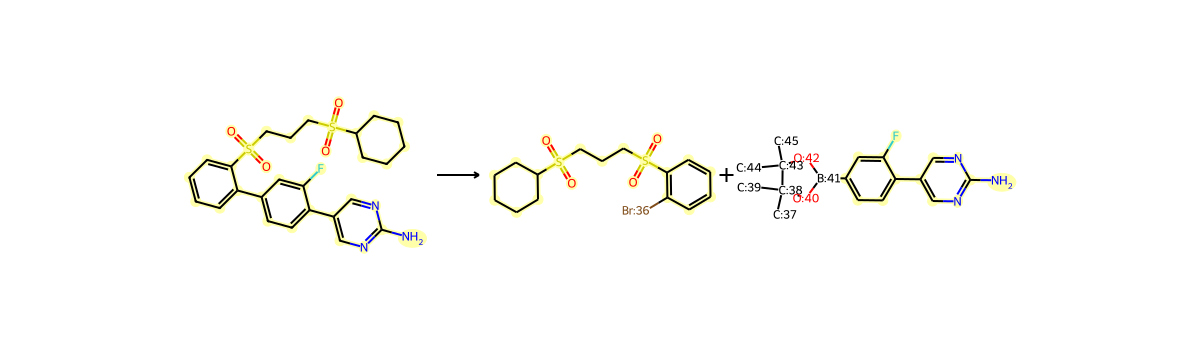

precedent reaction: US09079866B2__16025
similarity: 0.4661016949152542


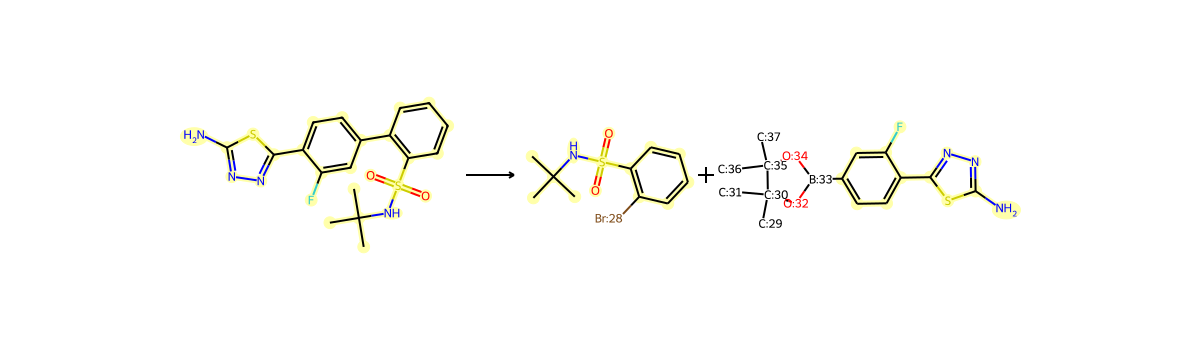

precedent reaction: US06887885B2__13482
similarity: 0.3700440528634361


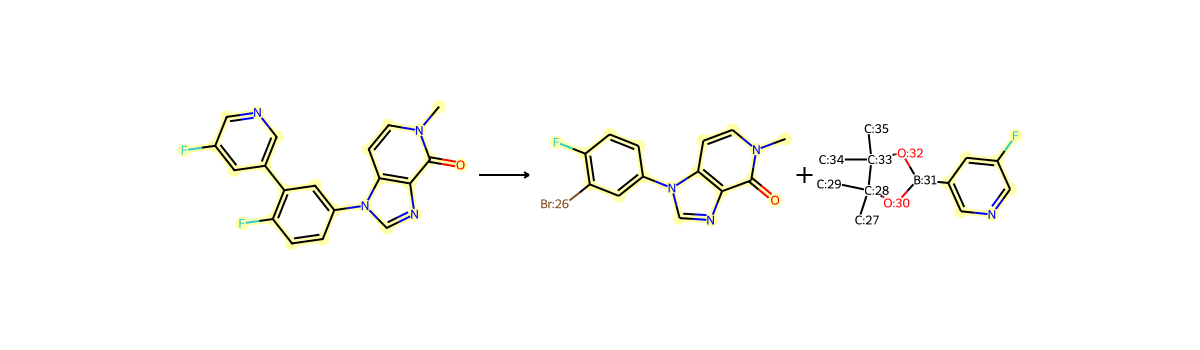

In [81]:
# finally, grab the top 10 precedent reactions and plot them
# This is similarity of precedent rxn to predicted rxn
for idx, reaction in enumerate(Seq0_precedent_rxns["reactions"]):
    if idx <=10:
       print("precedent reaction: " + reaction["id"] + "\n" + "similarity: " + str(reaction["similarity"]))
       rxn = rdChemReactions.ReactionFromSmarts(reaction["stdrsmi_periods"],useSmiles=True)
       rdChemReactions.SanitizeRxn(rxn)
       drawer = rdMolDraw2D.MolDraw2DSVG(1200,350)
       drawer.DrawReaction(rxn,highlightByReactant=True)
       drawer.FinishDrawing()
       display(SVG(drawer.GetDrawingText()))

## Bonus/ Self-study Stuff Below

In [ ]:
fail

In [ ]:
#########  CAUTION  ##########
#########  CAUTION  ##########
#########  CAUTION  ##########

# commenting out all code below here, in the event that you try "Run All" on this notebook
# you should be certain you want to run the below code before executing
# as it is not well tested, uses a lot of resources, and can take a long time.
# In addition, if you terminate the multiprocessing before it finishes
# it may not terminate subprocesses, you will have to run pool.terminate()

# Below is some code to process all predictions and then add the associated precedent rxns and similarity
# This is pretty complex, my thanks to Avery for the code!
# This uses multiprocessing as we are computing a lot of reaction fingerprints to get the similarity

# This can take a long time depending on your parameters and training dataset. For example, with the
# dataset we used and radius = 1, threshold = 10, there are over 7 million comparisons that need to be
# made between the precedent reactions and the predicted reactions!

# In hindsight, we should pre-compute the unique precedent rxn fingerprints (~30,000) and predictions (~60,000)
# then add them to precedent reactions dictionary first as
# this code below is actually computing the same fingerprints multiple times...

# On my 24 core workstation using 20 cores, this took 30 min.

# Take a look at the final updated_predictions_all variable to see the precedent reactions alongside the predictions


In [ ]:
# # total comparisons needed
# total_sum = 0
# for product_id, values in filtered_predictions_all.items():
#     for sequence in values["predictions"]:
#         sequence_predicted_smiles = sequence["predicted_rxn_smi"]
#         sequence_signature = sequence["Signature"]
#         sequence_precendent_rxns = precedent_rxns[sequence_signature]
#         total_sum += len(sequence_precendent_rxns["reactions"])

# print(total_sum)

In [ ]:
# import multiprocessing as mp
# import subprocess
# from rdkit import Chem, DataStructs
# from rdkit.Chem import AllChem, rdChemReactions
# from rdkit import RDLogger
# import os

# RDLogger.DisableLog('rdApp.*')

# # this can take a long time!
# def process_sequence(sequence, precedent_rxns, lillymol_path):
#     sequence_predicted_smiles = sequence["predicted_rxn_smi"]
#     sequence_signature = sequence["Signature"]
#     sequence_precendent_rxns = precedent_rxns[sequence_signature]

#     # Clean up precedent reactions
#     for reaction in sequence_precendent_rxns["reactions"]:
#         id = reaction['id']
#         precedent_rxn_plus = reaction['stdrsmi']
#         temp_file_name = f"_temp_plus_smiles_{os.getpid()}"

#         with open(temp_file_name, "w") as outfile:
#             outfile.write(precedent_rxn_plus + "\n")
        
#         cmd = [lillymol_path + "rxn_standardize", "-d", "d", "-s", temp_file_name]
#         try:
#             precident_reaction_period = subprocess.check_output(cmd, text=True)
#             reaction["stdrsmi_periods"] = precident_reaction_period.strip()
#         except subprocess.CalledProcessError as e:
#             reaction["stdrsmi_periods"] = None
#             reaction["similarity"] = -1  # failure
#             continue
#         finally:
#             os.remove(temp_file_name)

#         # Compute reaction similarity based on fingerprints
#         precedent_smiles = reaction['stdrsmi_periods']

#         # WARNING: I don't think mapping numbers matter
#         # However, agents do influence rxn fingerprint, I'm leaving them out here
#         # as the predicted reactions do not have agents
#         # Set up ReactionFingerprintParams with includeAgents=False

#         params = rdChemReactions.ReactionFingerprintParams()
#         params.includeAgents = False  # Do not include agents
#         params.fpSize = 2048          # Size of the fingerprint
#         params.fpType = rdChemReactions.FingerprintType.AtomPairFP
#         try:
#             predicted_rxn = rdChemReactions.ReactionFromSmarts(sequence_predicted_smiles, useSmiles=True)
#             rdChemReactions.SanitizeRxn(predicted_rxn)

#             precedent_rxn = rdChemReactions.ReactionFromSmarts(precedent_smiles, useSmiles=True)
#             rdChemReactions.SanitizeRxn(precedent_rxn)

#             predicted_fp = rdChemReactions.CreateDifferenceFingerprintForReaction(predicted_rxn, params)
#             precedent_fp = rdChemReactions.CreateDifferenceFingerprintForReaction(precedent_rxn, params)

#             similarity = DataStructs.TanimotoSimilarity(precedent_fp, predicted_fp)
#             reaction["similarity"] = similarity
#         except:
#             reaction["similarity"] = -1  # failure

#     # get top 100 only
#     sorted_reactions = sorted(sequence_precendent_rxns['reactions'], key=lambda x: x['similarity'], reverse=True)
#     sorted_reactions = sorted_reactions[:100]
#     sequence_precendent_rxns['reactions'] = sorted_reactions

#     sequence["precedent_rxns"] = sequence_precendent_rxns
#     return sequence

# def process_product(product_id, values, precedent_rxns, lillymol_path):
#     for sequence in values["predictions"]:
#         process_sequence(sequence, precedent_rxns, lillymol_path)
#     return product_id, values

# # We will use total cores - 4
# total_cores = int(mp.cpu_count())
# print(f"Total cores available: {total_cores}")
# num_cores = total_cores - 4
# print(f"Using {num_cores} cores for multiprocessing")

# pool = mp.Pool(processes=num_cores)

# results = [pool.apply_async(process_product, args=(product_id, values, precedent_rxns, lillymol_path))
#             for product_id, values in filtered_predictions_all.items()]

# pool.close()
# pool.join()

# updated_predictions_all = {result.get()[0]: result.get()[1] for result in results}

In [ ]:
# # If you interrupt above cell, it may not terminate subprocesses
# # I think this should work...
# pool.terminate()

In [ ]:
#list(updated_predictions_all.items())[0]

In [ ]:
# # grab an example prediction and print out all precedent reactions for reference
# data_point = list(updated_predictions_all.items())[5]

# data_point = {
#     data_point[0]: data_point[1]
# }

# for id in data_point:
#     for predictions in data_point[id]["predictions"]:
#         print("Predicted Reaction")
#         print(predictions["predicted_rxn_smi"])
#         print("Precedent Reactions")
#         for reaction in predictions["precedent_rxns"]["reactions"]:
#             print(reaction["similarity"], reaction["stdrsmi_periods"])


In [ ]:
# Old single core version

# for product_id, values in filtered_predictions_all.items():
#     for sequence in values["predictions"]:
#         sequence_predicted_smiles = sequence["predicted_rxn_smi"]
#         sequence_signature = sequence["Signature"]
#         sequence_precendent_rxns = precedent_rxns[sequence_signature]

#         # Clean up precedent reactions
#         for reaction in sequence_precendent_rxns["reactions"]:
#             id = reaction['id']
#             precedent_rxn_plus = reaction['stdrsmi']

#             with open("_temp_plus_smiles", "w") as outfile:
#                 outfile.write(precedent_rxn_plus + "\n")
#             # convert + to .    
#             cmd = [lillymol_path+"rxn_standardize", "-d", "d", "-s", "_temp_plus_smiles"]
#             try:
#                 # Run the command
#                 precident_reaction_period = subprocess.check_output(cmd, text=True)
#                 reaction["stdrsmi_periods"] = precident_reaction_period.strip()
#             except subprocess.CalledProcessError as e:
#                 print(f"Error standardizing reaction: {e.output}")
#                 reaction["stdrsmi_periods"] = None
#                 reaction["similarity"] = -1 # failure
#                 continue

#             # Compute reaction similarity based on fingerprints
#             precedent_smiles = reaction['stdrsmi_periods']

#             # WARNING: I don't think mapping numbers matter
#             # However, agents do influence rxn fingerprint, I'm leaving them out here
#             # as the predicted reactions do not have agents
#             # Set up ReactionFingerprintParams with includeAgents=False
#             params = rdChemReactions.ReactionFingerprintParams()
#             params.includeAgents = False  # Do not include agents
#             params.fpSize = 2048          # Size of the fingerprint
#             params.fpType = rdChemReactions.FingerprintType.AtomPairFP
#             try:
#                 predicted_rxn = rdChemReactions.ReactionFromSmarts(sequence_predicted_smiles, useSmiles=True)
#                 rdChemReactions.SanitizeRxn(predicted_rxn)

#                 precedent_rxn = rdChemReactions.ReactionFromSmarts(precedent_smiles, useSmiles=True)
#                 rdChemReactions.SanitizeRxn(precedent_rxn)

#                 # Calculate the difference fingerprint
#                 predicted_fp = rdChemReactions.CreateDifferenceFingerprintForReaction(predicted_rxn, params)
#                 precedent_fp = rdChemReactions.CreateDifferenceFingerprintForReaction(precedent_rxn, params)

#                 similarity = AllChem.DataStructs.TanimotoSimilarity(precedent_fp, predicted_fp)
#                 reaction["similarity"] = similarity
#             except:
#                 reaction["similarity"] = -1 # failure

#         # sort by highest similarity
#         sorted_reactions = sorted(sequence_precendent_rxns['reactions'], key=lambda x: x['similarity'], reverse=True)
#         # grab top 100
#         sorted_reactions = sorted_reactions[:100]
#         sequence_precendent_rxns['reactions'] = sorted_reactions
        
#         # Add the updated dictionary back to sequence data
#         sequence["precedent_rxns"] = sequence_precendent_rxns